


#**YULU Case Study**

##**1. Problem Statement**

* The primary business problem is a dip in Yulu's revenue. The objective of this analysis is to statistically determine which factors significantly impact the demand (count) for electric cycles.

* We will specifically investigate:

1. Whether the day of the week <font color = 'purple'>(workingday) affects the number of rentals</font>.

2. If rental demand changes significantly across <font color = 'purple'>different seasons</font>.

3. How different <font color = 'purple'>weather conditions</font> influence rental counts.

Answering these questions will provide actionable insights for Yulu to optimize operations, create targeted marketing, and build better revenue forecasts, directly addressing the revenue dip.

##**2 . Import data & sanity checks**

In [ ]:
# STEP 1: Goals, hypotheses, and base setup
 #--- Imports--
import numpy as np

import pandas as pd

import datetime

import matplotlib.pyplot as plt

import seaborn as sns

import copy

import math

from scipy.stats import poisson, binom, expon, geom,norm,uniform,ttest_1samp,ttest_rel,ttest_ind,chi2_contingency,chisquare,ttest_ind_from_stats,pearsonr,spearmanr
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.weightstats import ztest as stests
from scipy.stats import f_oneway # Numeric Vs categorical for many categories
from scipy.stats import ttest_ind # Numeric Vs categorical
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro
from scipy.stats import levene
from scipy.stats import kruskal,kstest
import statsmodels.api as sm
from statsmodels.formula.api import ols
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
!pip install -q pingouin
import pingouin as pg
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

###**2.1 Load Yulu CSV file**

In [ ]:
# Import dataset & basic sanity checks
# Load CSV
df = pd.read_csv("https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/001/428/original/bike_sharing.csv?1642089089")


###**2.2 Shape of data**

In [ ]:
#To find the shape of dataframe (rows,columns)
df.shape

(10886, 12)

###**2.3 Preview first few rows**

In [ ]:
# Preview first few rows
display(df.head())

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


###**2.4 Columns provided**

In [ ]:
# Column names and types
print("\nColumn dtypes:")
print(df.info())


Column dtypes:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB
None


In [ ]:
print(df.columns)

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')


###**2.5 Checking for duplicates**

In [ ]:
# Check duplicates
dup_count = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {dup_count}")


Number of duplicate rows: 0


###**2.6 Checking for Constant value columns**

In [ ]:
# Check if any column is constant (no variability)
constant_cols = [col for col in df.columns if df[col].nunique() == 1]
print(f"Constant columns (if any): {constant_cols}")


# Basic checks on count column
if "count" in df.columns:
  print("\nPurchase column check:")
  print("Min:", df["count"].min())
  print("Max:", df["count"].max())
  print("Any negatives?", (df["count"] < 0).any())

Constant columns (if any): []

Purchase column check:
Min: 1
Max: 977
Any negatives? False


###**2.7 Conversion of attributes to appropriate datatypes**

In [ ]:
#Conversion of datetime column
df['datetime'] = df['datetime'].astype("datetime64[ns]")

#Conversion of categorical columns
cat_cols = ['season', 'holiday', 'workingday', 'weather']
for col in cat_cols:
  df[col] = df[col].astype("string").str.strip().astype("category")

df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  category      
 2   holiday     10886 non-null  category      
 3   workingday  10886 non-null  category      
 4   weather     10886 non-null  category      
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: category(4), datetime64[ns](1), float64(3), int64(4)
memory usage: 723.7 KB


###**2.8 Binning for Numerical attributes**

In [ ]:
#Binning "temp" values:
temp_bins = [0, 10, 20, 30, 41]
temp_labels = ['Cold', 'Mild', 'Warm', 'Hot']
df['temp_category'] = pd.cut(df['temp'], bins=temp_bins, labels=temp_labels, include_lowest=True)

#Binning "atemp" values:
atemp_bins = [0, 10, 20, 30, 46] #(using 46 to make sure 45.455 is included)
atemp_labels = ['Feels Cold', 'Feels Mild', 'Feels Warm', 'Feels Hot']
df['atemp_category'] = pd.cut(df['atemp'], bins=atemp_bins, labels=atemp_labels, include_lowest=True)

#Bining humidity values:
humidity_bins = [0, 30, 60, 100]
humidity_labels = ['Dry', 'Comfortable', 'Humid']
df['humidity_category'] = pd.cut(df['humidity'], bins=humidity_bins, labels=humidity_labels, include_lowest=True)

#Binning windspeed
windspeed_bins = [0, 10, 25, 40, 57]
windspeed_labels = ['Calm', 'Light Breeze', 'Windy', 'Strong Wind']
df['windspeed_category'] = pd.cut(df['windspeed'], bins=windspeed_bins, labels=windspeed_labels, include_lowest=True)


new_order = ['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp','temp_category','atemp','atemp_category','humidity','humidity_category', 'windspeed','windspeed_category' ,'casual', 'registered', 'count']

# Reassign using .reindex()
df = df.reindex(columns=new_order)


In [ ]:
len(new_order)

16

###**2.8 Missing values per column**

In [ ]:
# STEP 4: Missing values detection & handling
# Count missing values per column
missing_counts = df.isnull().sum()

# Percentage of missing values
missing_percent = (df.isnull().mean() * 100).round(2)

# Combine into one table
missing_summary = pd.DataFrame({
"missing_count": missing_counts,
"missing_percent": missing_percent
}).sort_values("missing_percent", ascending=False)
display(missing_summary)

,missing_count,missing_percent
datetime,0,0.0
season,0,0.0
holiday,0,0.0
workingday,0,0.0
weather,0,0.0
temp,0,0.0
temp_category,0,0.0
atemp,0,0.0
atemp_category,0,0.0
humidity,0,0.0


* There are no missing values and no duplicates in any of the columns of the given dataset.

##**3. Statistical summary**

###**3.1 Numeric attributes**

In [ ]:
df.describe()

,datetime,temp,atemp,humidity,windspeed,casual,registered,count
count,10886,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2011-12-27 05:56:22.399411968,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
min,2011-01-01 00:00:00,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2011-07-02 07:15:00,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,2012-01-01 20:30:00,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,2012-07-01 12:45:00,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,2012-12-19 23:00:00,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000
std,NaN,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454


###**3.2 Categorical attributes**


In [ ]:
#Checking for unique values and their counts
cat_cols1 = ['season', 'holiday', 'workingday', 'weather','temp_category','atemp_category','humidity_category','windspeed_category']

for col in cat_cols1:
  print(df[col].value_counts(normalize=True))
  print('-------------------')

season
4    0.251148
2    0.251056
3    0.251056
1    0.246739
Name: proportion, dtype: float64
-------------------
holiday
0    0.971431
1    0.028569
Name: proportion, dtype: float64
-------------------
workingday
1    0.680875
0    0.319125
Name: proportion, dtype: float64
-------------------
weather
1    0.660665
2    0.260334
3    0.078909
4    0.000092
Name: proportion, dtype: float64
-------------------
temp_category
Warm    0.398126
Mild    0.371946
Cold    0.115653
Hot     0.114275
Name: proportion, dtype: float64
-------------------
atemp_category
Feels Warm    0.364137
Feels Hot     0.298549
Feels Mild    0.284310
Feels Cold    0.053004
Name: proportion, dtype: float64
-------------------
humidity_category
Humid          0.522139
Comfortable    0.432666
Dry            0.045196
Name: proportion, dtype: float64
-------------------
windspeed_category
Light Breeze    0.523425
Calm            0.398585
Windy           0.074316
Strong Wind     0.003674
Name: proportion, dtype: floa

In [ ]:
#Checking the statistics of the numerical columns
df.describe(include="category")

,season,holiday,workingday,weather,temp_category,atemp_category,humidity_category,windspeed_category
count,10886,10886,10886,10886,10886,10886,10886,10886
unique,4,2,2,4,4,4,3,4
top,4,0,1,1,Warm,Feels Warm,Humid,Light Breeze
freq,2734,10575,7412,7192,4334,3964,5684,5698


###**3.3 Comments on Range of Attributes**

<u>**Numerical Attributes**</u>
<br>
1. <font color='brown'>**count (Dependent Variable)** </font>

* Absolute Range: The rental count spans a very wide range, from a minimum of 1 to a maximum of 977 rentals in a single period.

* Typical Range (IQR): The middle 50% of rental periods fall between 42 (25th percentile) and 284 (75th percentile) rentals. This Interquartile Range (IQR) of 242 shows a substantial spread in typical demand.

* Skewness: The mean count (191.6) is significantly higher than the median (145.0). This suggests the distribution is right-skewed, meaning there are some high-demand periods (outliers) that pull the average up.
<br>

2. <font color='brown'>**casual and registered**</font>

* Observation: The registered users (mean: 155.6, median: 118) make up the vast majority of rentals compared to casual users (mean: 36.0, median: 17).

* Skewness: Both casual and registered distributions are also right-skewed, as their means are much larger than their medians. This is especially pronounced for casual users.

3. <font color='brown'>**temp(Temperature)**</font>

* Absolute Range: The temp (actual temperature) ranges from 0.82°C (near-freezing) to 41.0°C (very hot).

4. <font color='brown'>**atemp (feeling temperature)**<font>

* It has a similar range (0.76°C to 45.45°C), indicating the data captures a full spectrum of weather conditions. The slightly higher maximum atemp suggests that high humidity/low wind can make hot days feel even hotter.

5. <font color='brown'>**humidity**</font>

* Absolute Range: The humidity attribute covers the entire possible range, from 0.0% (extremely dry) to 100.0% (fully saturated).

* Typical Range (IQR): The middle 50% of observations are between 47.0% and 77.0%.

* Distribution: The mean (61.9%) and median (62.0%) are almost identical, suggesting the humidity distribution is roughly symmetric (normal-like).

6. <font color='brown'>**windspped**</font>

* Absolute Range: windspeed ranges from 0.0 (completely calm) to 56.99 (very high wind).

* Skewness: The mean (12.8) is slightly lower than the median (13.0), but the 75th percentile is 17.0, while the max is almost 57. This indicates the distribution is right-skewed due to some observations with very high windspeed.

7. <font color='brown'>**datetime (Identifier)**</font>

* This attribute is not a numerical feature for statistical analysis in this context.

* Observation: The min (2011-01-01) and max (2012-12-19) are crucial. They tell us the dataset covers exactly two years (2011 and 2012). This is very important for analyzing seasonal or yearly trends.

<u>**Categorical Attributes**</u>

1. <font color='brown'>**season**</font>

* This attribute has 4 unique categories (1: spring, 2: summer, 3: fall, 4: winter).

* The top category is 4 (winter), with 2,734 observations. All four seasons appear to be well-represented in the dataset.

2. <font color='brown'>**holiday**</font>

* This attribute is binary, with 2 unique categories (0: No Holiday, 1: Holiday).

*  The top category is 0 with a frequency of 10,575. This means holidays (1) are very rare in the dataset, making up less than 3% of the data.

3. <font color='brown'>**workingday**</font>

* This attribute is binary, with 2 unique categories (0: Weekend/Holiday, 1: Working Day).

* The top category is 1 with a frequency of 7,412. This shows the dataset is roughly 68% working days and 32% non-working days.

4. <font color='brown'>**weather**</font>

* This attribute has 4 unique categories representing weather conditions from Clear (1) to Heavy Rain/Snow (4).

* The top category is 1 (Clear, Few clouds), which accounts for 7,192 of the 10,886 observations. This indicates that most of the data was recorded during good weather.

<u>**Binned Categories**</u>

These are the new categories you created:

1. <font color='brown'>**temp_category:**</font>

* Has 4 unique categories. The most frequent (top) is 'Warm' (20-30°C) with 4,396 observations.

2. <font color='brown'>**atemp_category:**</font>
* Has 4 unique categories. The most frequent is 'Feels Warm' (20-30°C) with 4,568 observations, similar to temp_category.

3. <font color='brown'>**humidity_category:**</font>
* Has 3 unique categories. The most frequent is 'Humid' (60-100%) with 5,684 observations.

4. <font color='brown'>**windspeed_category:**</font>
* Has 4 unique categories. The most frequent is 'Light Breeze' (10-25) with 4,569 observations.

##**4. Non-Graphical Analysis ​**

In [ ]:
#Checking for unique values
df.nunique()

,0
datetime,10886
season,4
holiday,2
workingday,2
weather,4
temp,49
temp_category,4
atemp,60
atemp_category,4
humidity,89


In [ ]:
#Checking for unique values and their counts
cat_cols1 = ['season', 'holiday', 'workingday', 'weather','temp_category','atemp_category','humidity_category','windspeed_category']

for col in cat_cols1:
  col_name = str(col)
  print(col_name,':',df[col].unique())
  print('-------------------')

season : ['1', '2', '3', '4']
Categories (4, string): [1, 2, 3, 4]
-------------------
holiday : ['0', '1']
Categories (2, string): [0, 1]
-------------------
workingday : ['0', '1']
Categories (2, string): [0, 1]
-------------------
weather : ['1', '2', '3', '4']
Categories (4, string): [1, 2, 3, 4]
-------------------
temp_category : ['Cold', 'Mild', 'Warm', 'Hot']
Categories (4, object): ['Cold' < 'Mild' < 'Warm' < 'Hot']
-------------------
atemp_category : ['Feels Mild', 'Feels Warm', 'Feels Cold', 'Feels Hot']
Categories (4, object): ['Feels Cold' < 'Feels Mild' < 'Feels Warm' < 'Feels Hot']
-------------------
humidity_category : ['Humid', 'Comfortable', 'Dry']
Categories (3, object): ['Dry' < 'Comfortable' < 'Humid']
-------------------
windspeed_category : ['Calm', 'Light Breeze', 'Windy', 'Strong Wind']
Categories (4, object): ['Calm' < 'Light Breeze' < 'Windy' < 'Strong Wind']
-------------------


###4.1 Unique attributes in categorical columns:

* season: 4 ('1', '2', '3', '4')

* holiday: 2 ('0', '1')

* workingday: 2 ('0', '1')

* weather: 4 ('1', '2', '3', '4')

* temp_category: 4 ('Cold', 'Mild', 'Warm', 'Hot')

* atemp_category: 4 ('Feels Mild', 'Feels Warm', 'Feels Cold', 'Feels Hot')

* humidity_category: 3 ('Humid', 'Comfortable', 'Dry')

* windspeed_category: 4 ('Calm', 'Light Breeze', 'Windy', 'Strong Wind')



## **5. Visual Analysis - Univariate & Bivariate**

###**5.1 For Continuous variables(Univariate):**




In [ ]:
#Numerical columns:
Count = df['count']
Registered = df['registered']
casual = df['casual']
windspeed = df['windspeed']
humidity = df['humidity']
atemp = df['atemp']
temp = df['temp']


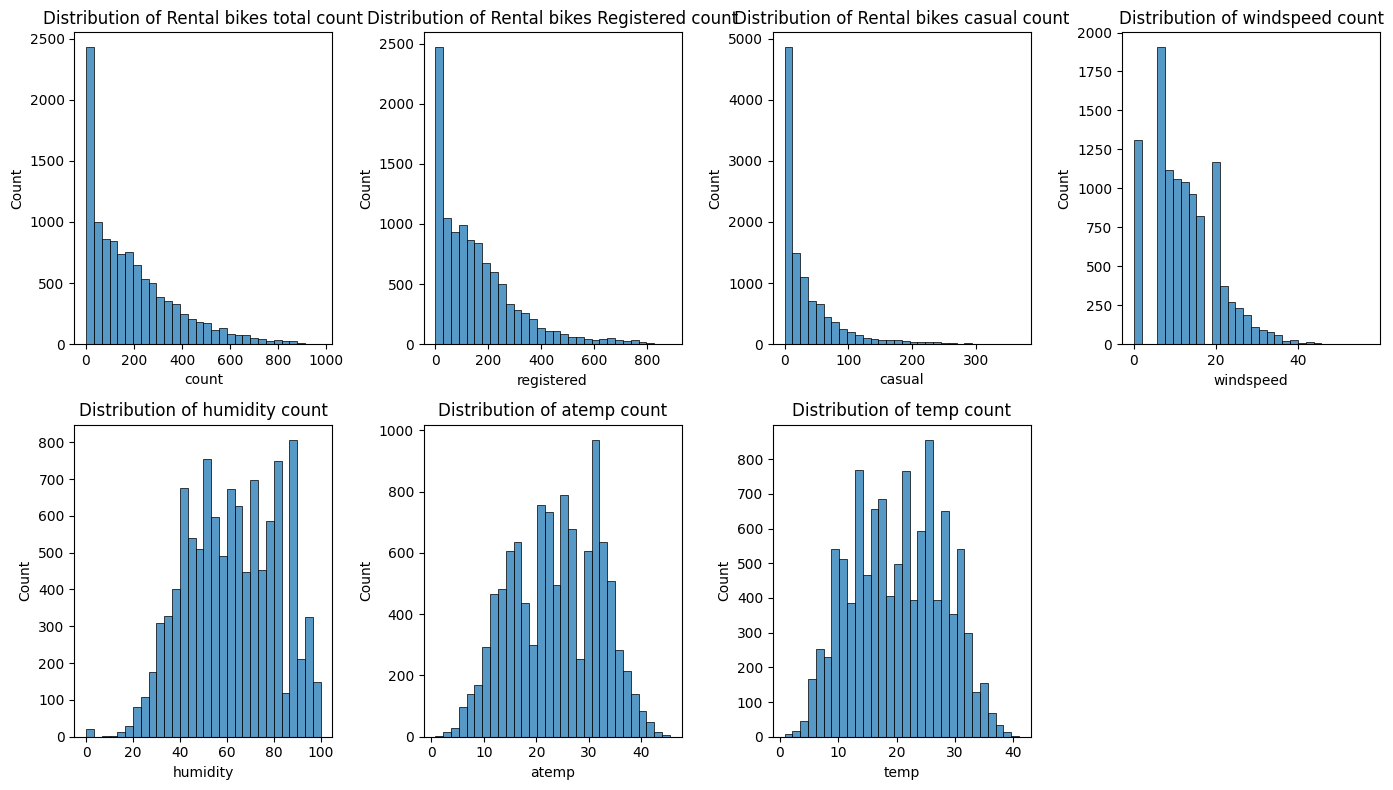

In [ ]:
#Histogram for continuous variables

fig,axes = plt.subplots(2,4,figsize=(14,8))

sns.histplot(data=df,x="count",bins=30,ax= axes[0,0])
axes[0,0].set_title("Distribution of Rental bikes total count")

sns.histplot(data=df,x="registered",bins=30,ax= axes[0,1])
axes[0,1].set_title("Distribution of Rental bikes Registered count")

sns.histplot(data=df,x="casual",bins=30,ax= axes[0,2])
axes[0,2].set_title("Distribution of Rental bikes casual count")

sns.histplot(data=df,x="windspeed",bins=30,ax= axes[0,3])
axes[0,3].set_title("Distribution of windspeed count")

sns.histplot(data=df,x="humidity",bins=30,ax= axes[1,0])
axes[1,0].set_title("Distribution of humidity count")

sns.histplot(data=df,x="atemp",bins=30,ax= axes[1,1])
axes[1,1].set_title("Distribution of atemp count")

sns.histplot(data=df,x="temp",bins=30,ax= axes[1,2])
axes[1,2].set_title("Distribution of temp count")

axes[1, 3].axis('off')

plt.tight_layout()
plt.show()

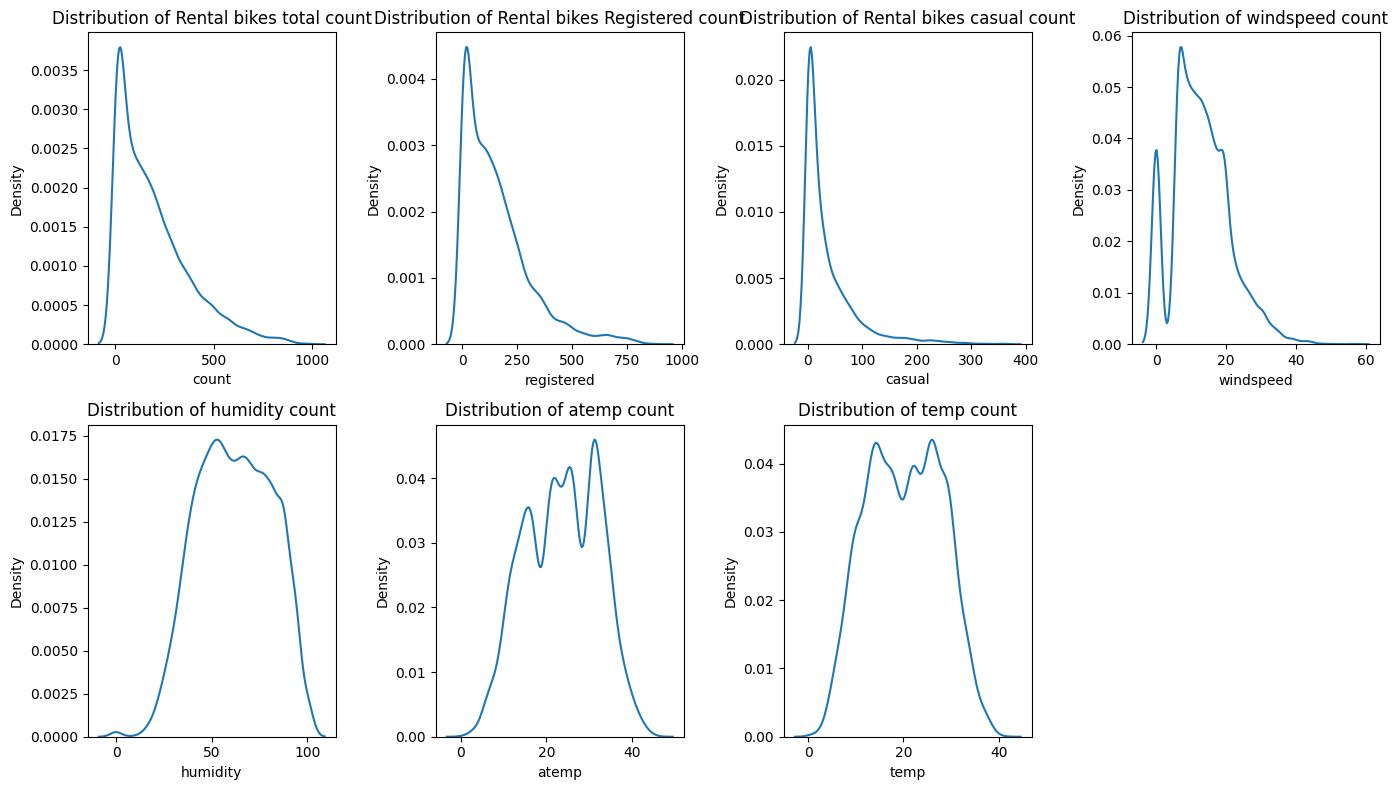

In [ ]:
#Kde for Continuous Variables
fig,axes = plt.subplots(2,4,figsize=(14,8))

sns.kdeplot(data=df,x="count",ax= axes[0,0])
axes[0,0].set_title("Distribution of Rental bikes total count")

sns.kdeplot(data=df,x="registered",ax= axes[0,1])
axes[0,1].set_title("Distribution of Rental bikes Registered count")

sns.kdeplot(data=df,x="casual",ax= axes[0,2])
axes[0,2].set_title("Distribution of Rental bikes casual count")

sns.kdeplot(data=df,x="windspeed",ax= axes[0,3])
axes[0,3].set_title("Distribution of windspeed count")

sns.kdeplot(data=df,x="humidity",ax= axes[1,0])
axes[1,0].set_title("Distribution of humidity count")

sns.kdeplot(data=df,x="atemp",ax= axes[1,1])
axes[1,1].set_title("Distribution of atemp count")

sns.kdeplot(data=df,x="temp",ax= axes[1,2])
axes[1,2].set_title("Distribution of temp count")

axes[1, 3].axis('off')

plt.tight_layout()
plt.show()

<u>**count, registered, casual**:</u>
<br>
* All three (count, registered, casual) are right-skewed. We can see this clearly because they are "piled up" on the left (lots of low-demand periods) and have a long tail stretching to the right (a few high-demand periods).

* **Business Insight**: This shape tells us that extremely high-demand days (e.g., 500+ rentals) are rare events, while the vast majority of days see a much lower, more concentrated number of rentals.

<u>**temp,atemp**</u>
* They are much more symmetric. The distribution is multimodal. This is very common in temperature data, as the peaks often correspond to the average temperatures of the different seasons (e.g., a "winter peak," a "summer peak").

* **Business Insight**: And yes, they look almost identical. This tells us that temp and atemp are very, very strongly related. The "feeling" temperature closely tracks the actual temperature, which makes perfect sense.

<u>**humidity**</u>
* This distribution is complex and not a simple bell curve. It appears to be left-skewed, with most observations clustered at higher humidity levels (60-100%). It also has a strange, small, separate peak at 0, which could be an anomaly or a code for missing data.

<u>**windspeed**</u>
* This distribution is right-skewed, with a long tail of rare, high-wind-speed days. The histogram reveals a complex, multimodal shape.It has the single most frequent, narrow range (the mode) is around 7-9. There is also a second, very large spike at 0 (no wind).



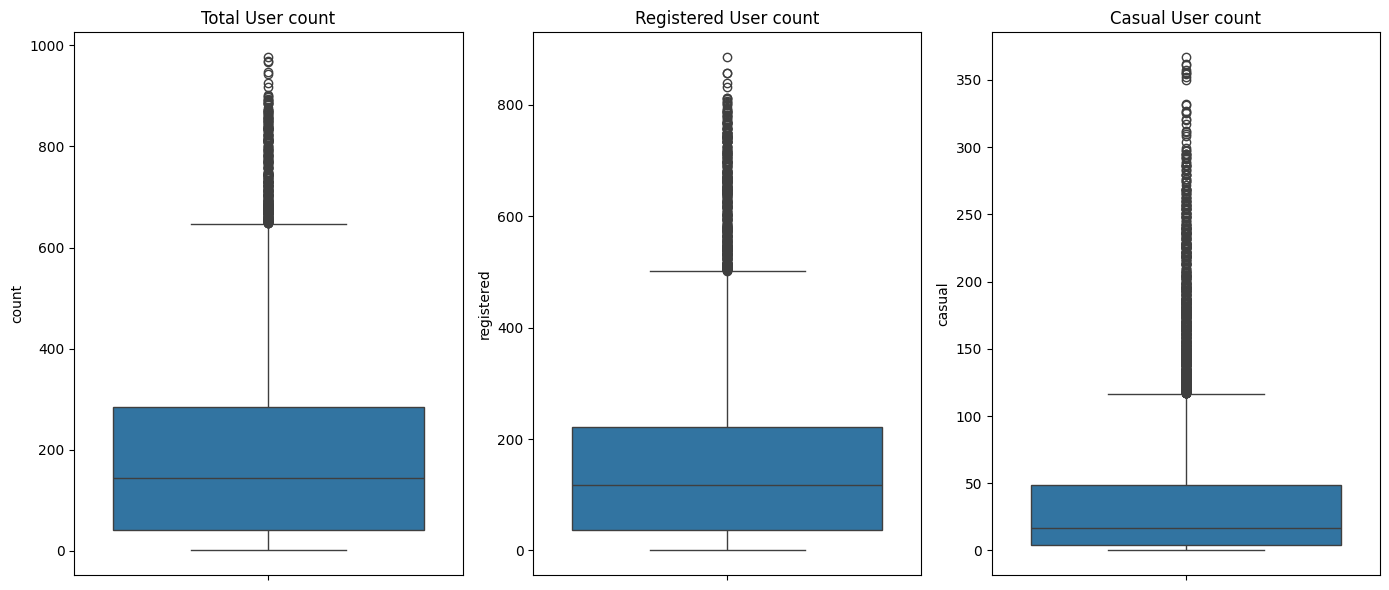

In [ ]:
#Boxplot for Dependent/Target variables - count,registered,casual

fig,axes = plt.subplots(1,3,figsize=(14,6))

sns.boxplot(data=df, y="count",ax = axes[0])
axes[0].set_title("Total User count")

sns.boxplot(data=df, y="registered",ax = axes[1])
axes[1].set_title("Registered User count")

sns.boxplot(data=df, y="casual",ax = axes[2])
axes[2].set_title("Casual User count")

plt.tight_layout()
plt.show()

1. <font color=purple>Confirms Strong Right-Skew:</font> This is the most obvious insight. For all three plots, the main "box" (which holds the middle 50% of your data) is packed into the bottom of the range. The median (the white line) is in the lower half of the box. This, combined with the long "whisker" on top, is a classic visual signature of the strong right-skew you saw in the histograms. It means most days have low-to-medium rentals.

2. <font color=purple>"Outliers" are a Normal Feature:</font> Look at the huge number of dots (outliers) above the top whisker. This is not a mistake! This tells you that while most days are low-demand, there are many individual days with very high demand. These high-demand days are a regular and expected (though infrequent) part of the business, not just one or two random errors.

3. <font color=purple>registered Users are the Core Business:</font> By comparing the registered and casual plots, you get a clear business insight:

* **casual:** The median is very low (around 17), and the entire box is very "squished" between 0 and 50. Most of the time, casual rentals are extremely low.

* **registered:** The median is much higher (around 120), and the "typical" day (the box) ranges from ~35 to ~220.

This shows that the business's stable, predictable demand comes from its registered users. The casual user demand is much smaller and more sporadic.

###**5.2 For Categorical variables(Univariate):**

####**5.2.1 season:**

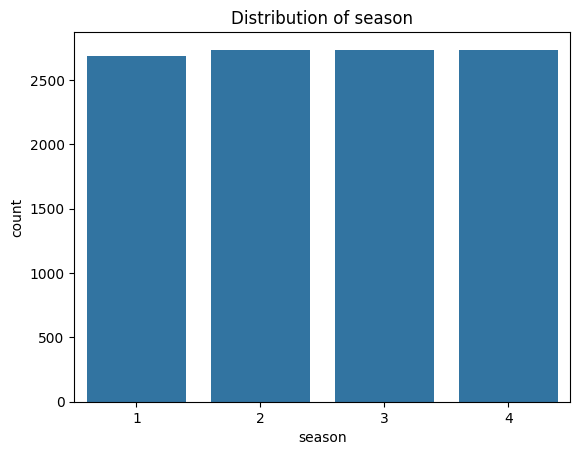

In [ ]:
#Countplot for season distribution
sns.countplot(data=df,x="season",order=['1', '2', '3', '4'])
plt.title("Distribution of season")
plt.show()

* The dataset is extremely well-balanced across the four seasons.

* Each season (1: spring, 2: summer, 3: fall, 4: winter) has an almost identical number of observations, right around 2,700.



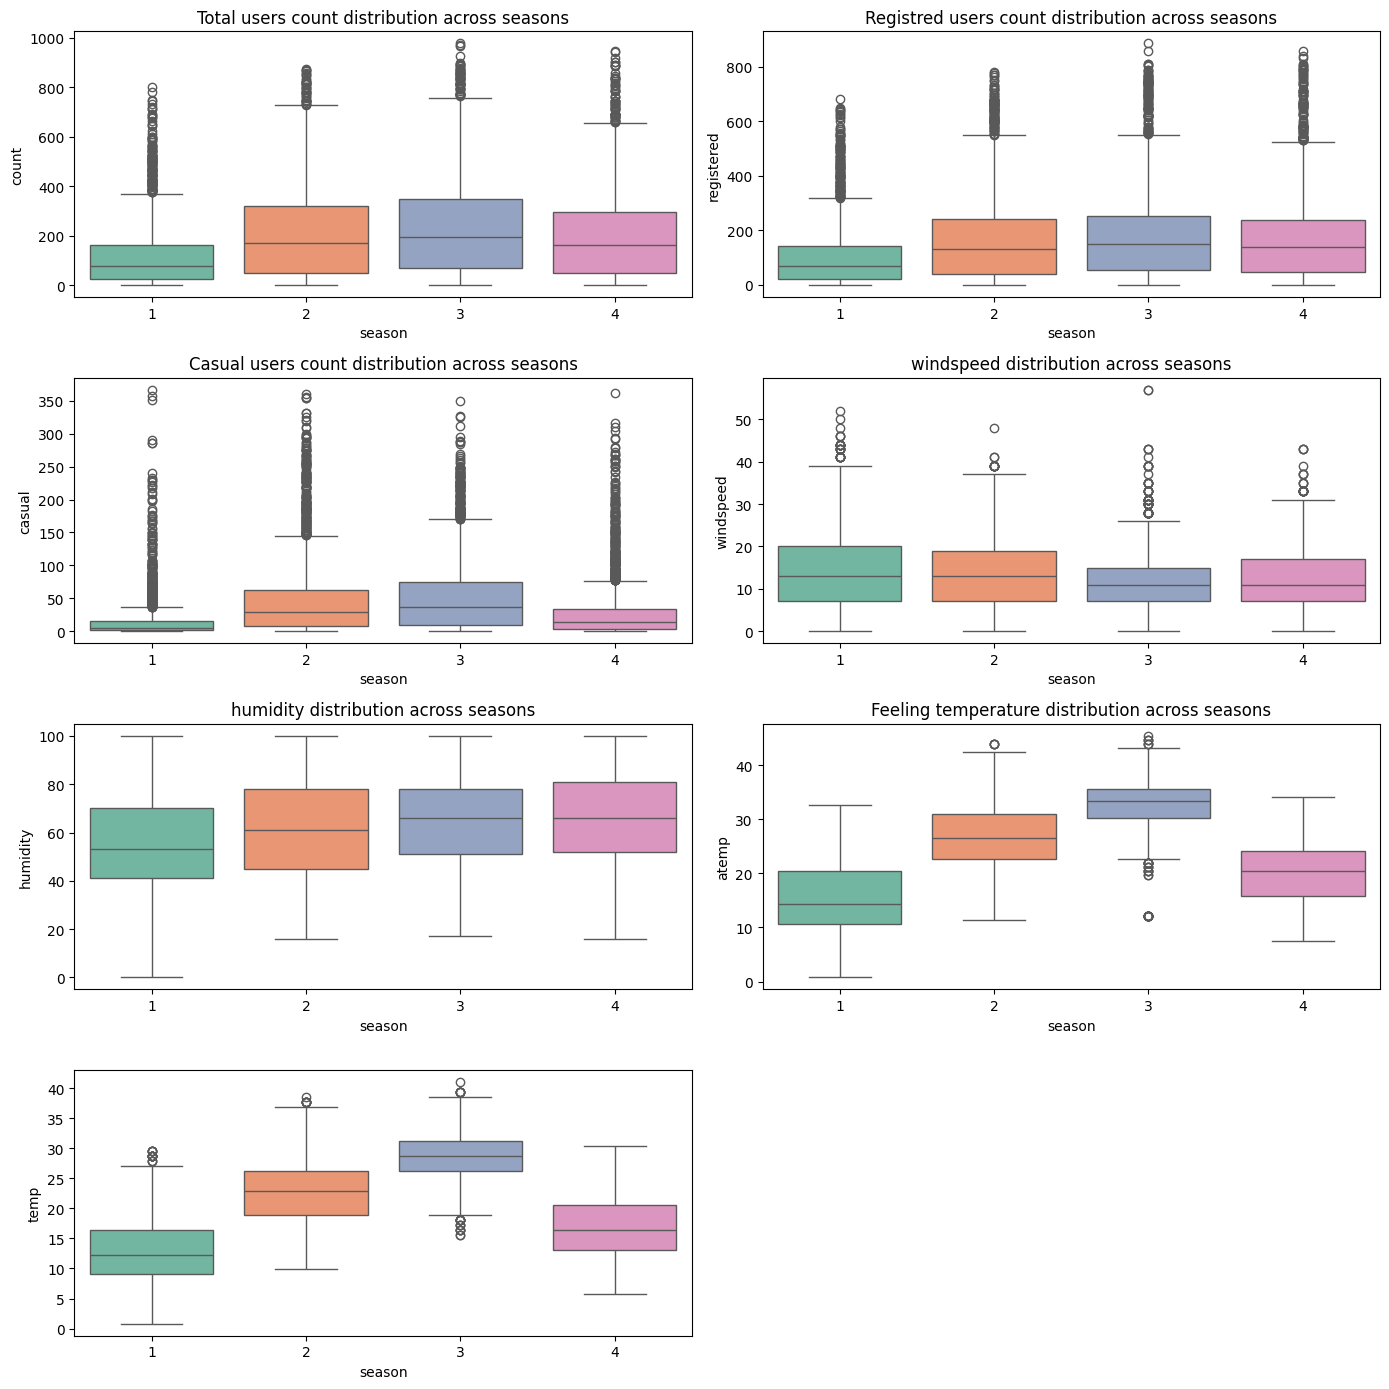

In [ ]:
#Boxplot - To compare and understand the distribution of continuous variables across seasons.

fig,axes = plt.subplots(4,2,figsize=(14,14))


sns.boxplot(data=df, x="season",y='count',palette="Set2",ax = axes[0,0])
axes[0,0].set_title("Total users count distribution across seasons")

sns.boxplot(data=df, x="season",y='registered',palette="Set2",ax = axes[0,1])
axes[0,1].set_title("Registred users count distribution across seasons")

sns.boxplot(data=df, x="season",y='casual',palette="Set2",ax = axes[1,0])
axes[1,0].set_title("Casual users count distribution across seasons")

sns.boxplot(data=df, x="season",y='windspeed',palette="Set2",ax = axes[1,1])
axes[1,1].set_title("windspeed distribution across seasons")

sns.boxplot(data=df, x="season",y='humidity',palette="Set2",ax = axes[2,0])
axes[2,0].set_title("humidity distribution across seasons")

sns.boxplot(data=df, x="season",y='atemp',palette="Set2",ax = axes[2,1])
axes[2,1].set_title("Temperature across seasons")

sns.boxplot(data=df, x="season",y='temp',palette="Set2",ax = axes[3,0])
axes[2,1].set_title("Feeling temperature distribution across seasons")

axes[3,1].axis('off')

plt.tight_layout()
plt.show()

1. The Most Important Insight: **The Season Labels are Wrong**

The metadata says 1: spring, 2: summer, 3: fall, 4: winter. This is incorrect.

* A look at the <font color='dark orange'>temp and atemp</font> boxplots shows the real order by temperature, from coldest to hottest:

* Season 1 has the lowest temperature, Season 4 is the next coldest, Season 2 is warmer than Season 4, Season 3 is the hottest.

This temperature order (1 < 4 < 2 < 3) does not match the metadata. It suggests a logical mapping of:

* **1** = Winter (Coldest)

* **4** = Spring (Warming up)

* **2** = Fall (Still warm, cooling down from summer)

* **3** = Summer (Hottest)

So for the rest of this analysis, we will use this corrected mapping: **(1: Winter, 2: Fall, 3: Summer, 4: Spring)**.

<br>

2. **Insights on Rental Demand (Total, Registered, Casual)**
Now that we have the correct seasons, the demand plots make perfect sense:

**Demand Follows Temperature**: The primary insight is that bike rental demand is directly related to the seasons. The median count follows the exact same pattern as temperature: Winter (1) < Spring (4) < Fall (2) < Summer (3).

**count (Total Users):**

* Demand is lowest in Winter (1).

* It increases significantly in Spring (4).

* It increases further in Fall (2).

* It peaks in Summer (3), which has the highest median and largest box (IQR), meaning demand is both highest and most variable.

**registered vs. casual Users:**

* Both user types follow this same pattern: demand is lowest in Winter (1), grows in Spring (4), is high in Fall (2), and peaks in Summer (3).

* This shows that the good weather of the warmer seasons attracts both committed registered users and new casual users.

3. **Insights on Environmental Factors**

* **windspeed**: The plot shows that Summer (3) tends to have the lowest median wind speed and less variability (a smaller box). Conversely, Winter (1) has the highest median wind speed. This lower wind speed in summer could be another factor (along with high temps) that makes riding more appealing.

* **humidity:** Winter (1) has the lowest median humidity. Humidity increases in Spring (4), and is at its highest levels in Fall (2) and Summer (3). This high humidity doesn't seem to stop people from renting, as these are also the two highest rental seasons.

####**5.2.2 holiday:**

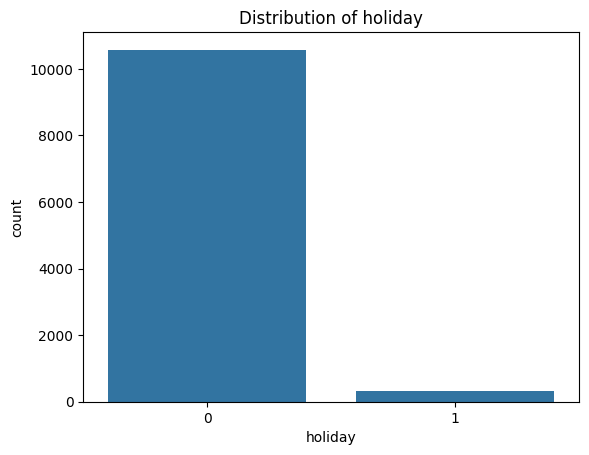

In [ ]:
#Countplot for holiday distribution
sns.countplot(data=df,x="holiday",order=['0','1'])
plt.title("Distribution of holiday")
plt.show()

This plot shows that the dataset is highly imbalanced for the holiday variable.

* Dominant Class: The vast majority of the days in the dataset are non-holidays (represented by 0), with a count of over 10,000.

* Rare Class: Actual holidays (represented by 1) are very rare in comparison, making up only a very small fraction of the data (around 300-400).


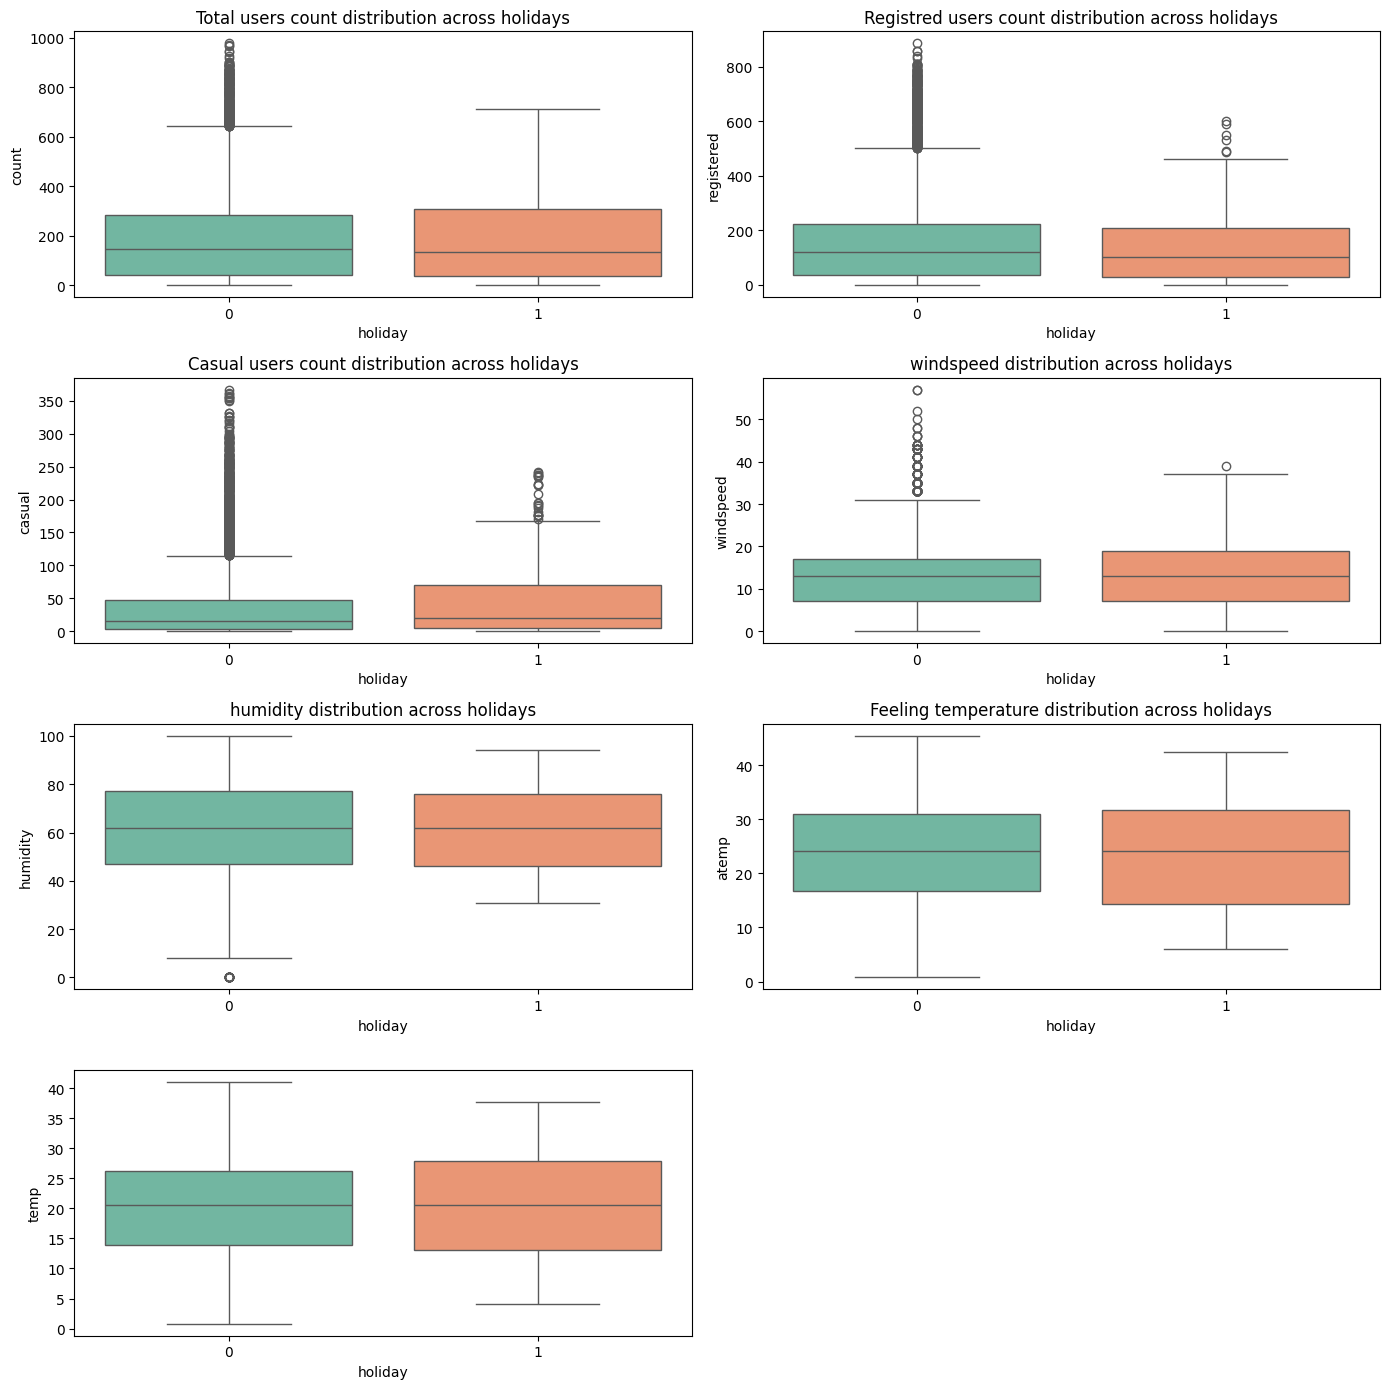

In [ ]:
#Boxplot - To compare and understand the distribution of continuous variables across holidays.

fig,axes = plt.subplots(4,2,figsize=(14,14))


sns.boxplot(data=df, x="holiday",y='count',palette="Set2",ax = axes[0,0])
axes[0,0].set_title("Total users count distribution across holidays")

sns.boxplot(data=df, x="holiday",y='registered',palette="Set2",ax = axes[0,1])
axes[0,1].set_title("Registred users count distribution across holidays")

sns.boxplot(data=df, x="holiday",y='casual',palette="Set2",ax = axes[1,0])
axes[1,0].set_title("Casual users count distribution across holidays")

sns.boxplot(data=df, x="holiday",y='windspeed',palette="Set2",ax = axes[1,1])
axes[1,1].set_title("windspeed distribution across holidays")

sns.boxplot(data=df, x="holiday",y='humidity',palette="Set2",ax = axes[2,0])
axes[2,0].set_title("humidity distribution across holidays")

sns.boxplot(data=df, x="holiday",y='atemp',palette="Set2",ax = axes[2,1])
axes[2,1].set_title("Temperature across holidays")

sns.boxplot(data=df, x="holiday",y='temp',palette="Set2",ax = axes[3,0])
axes[2,1].set_title("Feeling temperature distribution across holidays")

axes[3,1].axis('off')

plt.tight_layout()
plt.show()

1. **Holidays Change Who Rents, Not Just If They Rent**

This is the most important insight, revealed by comparing the casual and registered plots:

* **registered Users (Commuters)**: Demand from registered users is noticeably lower on holidays. The median line for holiday=1 is clearly lower than for holiday=0. This makes perfect sense, as these are likely commuters who are not going to work.

* **casual Users (Leisure)**: Demand from casual users is significantly higher on holidays. The entire box (IQR) for holiday=1 is shifted upwards, and the median is much higher. This shows that holidays drive an increase in leisure rentals.

2. **The Net Effect on Total Users is Small**

**Total users count (count)**: When you combine the registered drop and the casual spike, the net effect on count is small. The median count on holidays (1) is only slightly higher than on non-holidays (0). The main difference is that the rental counts on holidays seem to be more variable (a taller box).

3. **Environmental Factors are Not a Factor**

**temp, atemp, windspeed, humidity:** The distributions for all four environmental variables look almost identical between holidays (1) and non-holidays (0).

Why this is important: This is great news for your analysis. It means that holidays are not concentrated in a specific season or weather type (e.g., it's not like "all holidays are on warm, calm days"). This gives you confidence that any difference in rental counts is due to the holiday itself, not a hidden weather effect.

####**5.2.3 workingday:**

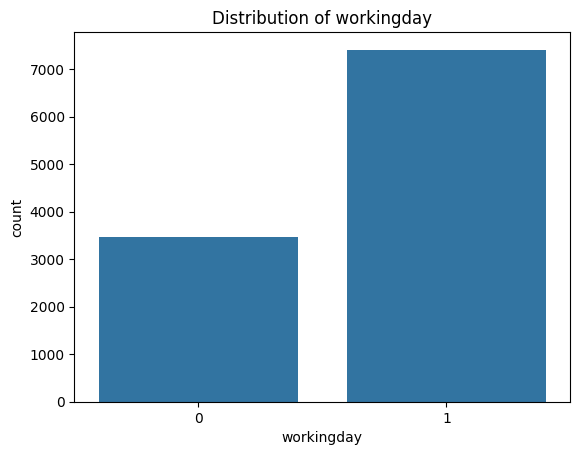

In [ ]:
#Countplot for workingday distribution
sns.countplot(data=df,x="workingday",order=['0','1'])
plt.title("Distribution of workingday")
plt.show()

* **Dataset Composition:** The plot shows the dataset is composed of roughly two-thirds working days (1) and one-third non-working days (0).

* **Counts:** There are approximately 7,400 observations for working days, compared to about 3,500 for non-working days (which include weekends and holidays).

* **Analysis Implication:** This is a good, solid distribution for your analysis. Unlike the holiday variable, which was highly imbalanced, this workingday variable has a substantial number of observations in both categories. This makes it ideal for your upcoming 2-sample t-test, as you can confidently compare the two groups.

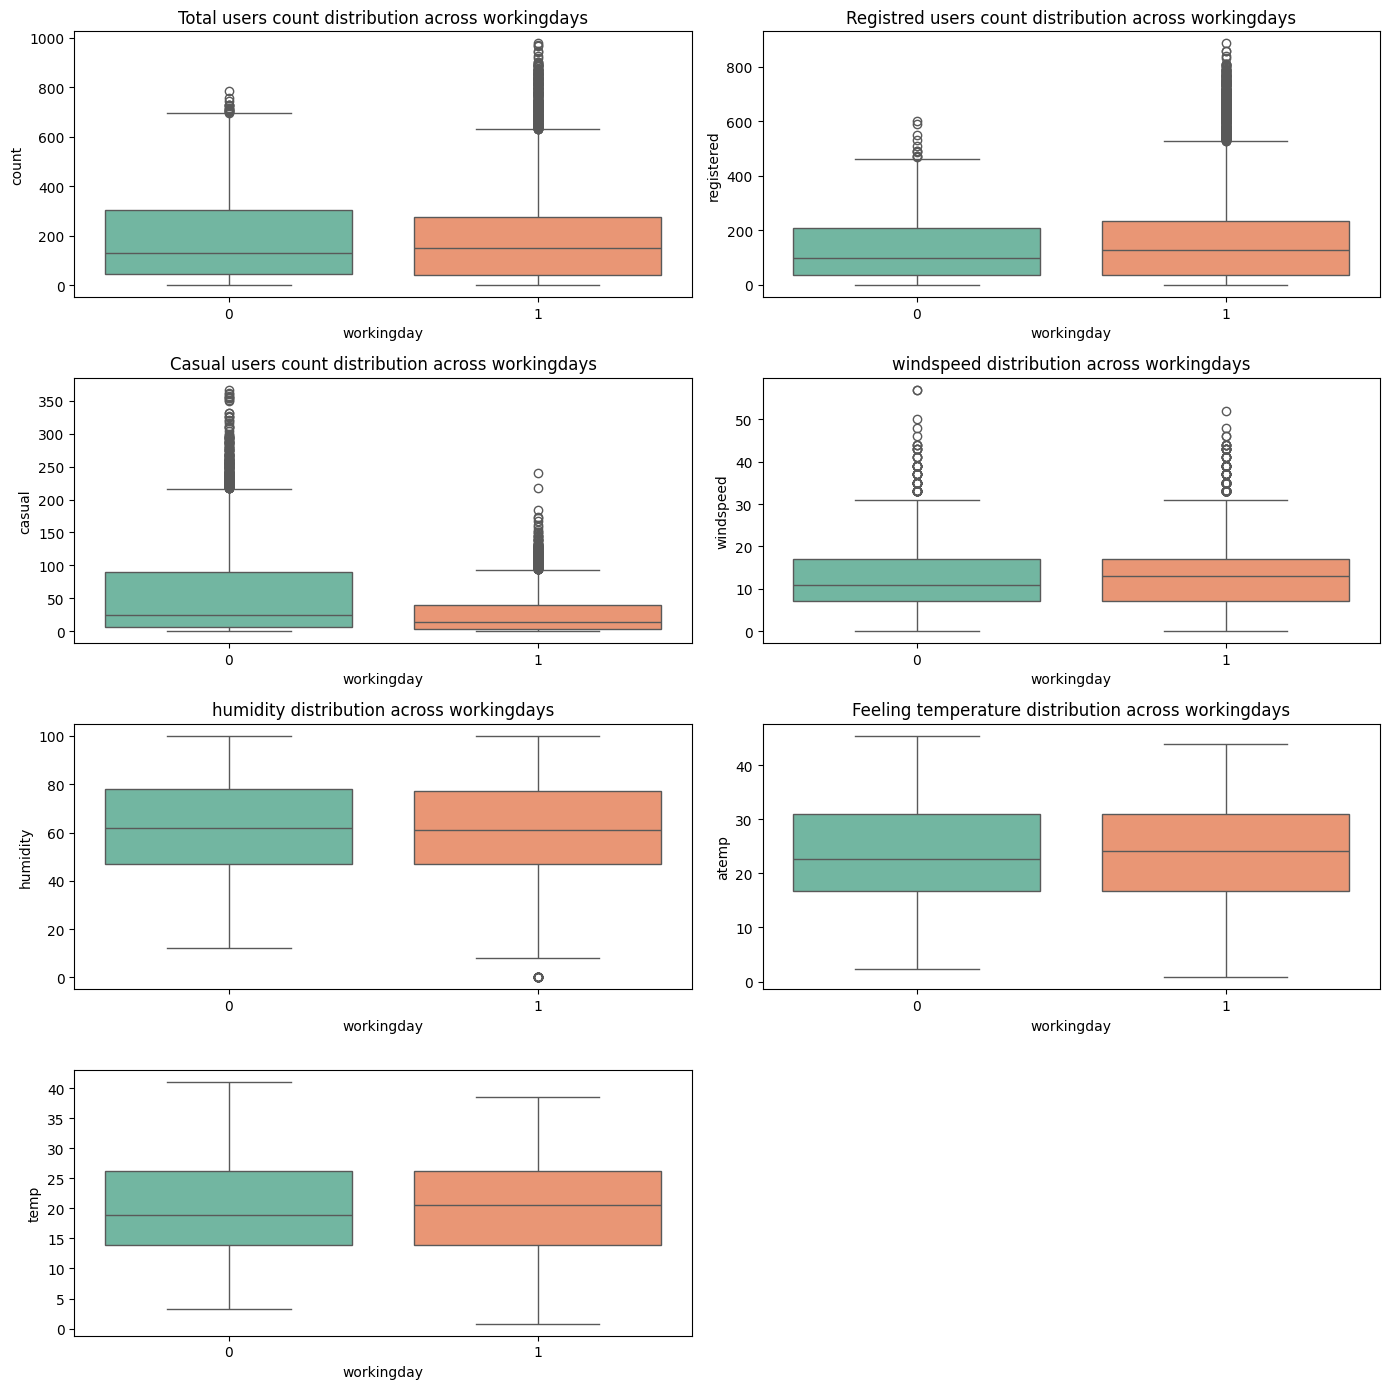

In [ ]:
#Boxplot - To compare and understand the distribution of continuous variables across workingdays.

fig,axes = plt.subplots(4,2,figsize=(14,14))


sns.boxplot(data=df, x="workingday",y='count',palette="Set2",ax = axes[0,0])
axes[0,0].set_title("Total users count distribution across workingdays")

sns.boxplot(data=df, x="workingday",y='registered',palette="Set2",ax = axes[0,1])
axes[0,1].set_title("Registred users count distribution across workingdays")

sns.boxplot(data=df, x="workingday",y='casual',palette="Set2",ax = axes[1,0])
axes[1,0].set_title("Casual users count distribution across workingdays")

sns.boxplot(data=df, x="workingday",y='windspeed',palette="Set2",ax = axes[1,1])
axes[1,1].set_title("windspeed distribution across workingdays")

sns.boxplot(data=df, x="workingday",y='humidity',palette="Set2",ax = axes[2,0])
axes[2,0].set_title("humidity distribution across workingdays")

sns.boxplot(data=df, x="workingday",y='atemp',palette="Set2",ax = axes[2,1])
axes[2,1].set_title("Temperature across workingdays")

sns.boxplot(data=df, x="workingday",y='temp',palette="Set2",ax = axes[3,0])
axes[2,1].set_title("Feeling temperature distribution across workingdays")

axes[3,1].axis('off')

plt.tight_layout()
plt.show()

1. <font color=brown>Clear "Commuter vs. Leisure" Pattern</font> The most important insight is that the two user groups behave in completely opposite ways:

**registered Users (Commuters)**: Demand is visibly higher on working days (1). This strongly suggests registered users are primarily commuters using the bikes for work.

**casual Users (Leisure)**: Demand is significantly higher on non-working days (0). This indicates casual users are renting for leisure on weekends and holidays.

2. <font color=brown>Impact on Total Demand (Corrected)</font> These two opposing patterns have a clear net effect on the total user count:

**Working Days are Typically Busier**: The code confirms the median count is higher on working days (1 = 151.0) than on non-working days (0 = 128.0).

**Business Meaning**: This shows that the registered (commuter) user base is the primary driver of demand. The increase in commuter rentals on a workday is more significant than the increase in leisure rentals on a non-workday.

**Higher Variability on Non-Workdays**: The box for non-working days (0) is much taller and wider (a larger IQR). This is a key insight: while the typical non-workday is quieter, its demand is less predictable and has a wider range of outcomes (more very quiet days, but also some very busy days).

3. <font color=brown>Environmental Factors are Consistent</font>  The boxplots for temp, atemp, humidity, and windspeed are all nearly identical for both day types. This is a crucial finding, as it confirms the differences in demand are due to the day type itself (work vs. leisure), not because one group just happened to have better weather. This makes our upcoming t-test a fair comparison.

####**5.2.4 weather:**

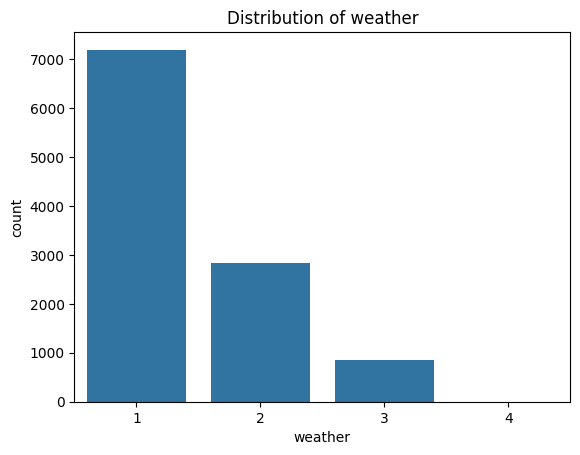

In [ ]:
#Countplot for weather distribution
sns.countplot(data=df,x="weather",order=['1','2','3','4'])
plt.title("Distribution of weather")
plt.show()

**Highly Imbalanced Data:** The dataset is highly skewed toward good weather.

**Dominant Category:** <font color=brown>Weather type 1 (Clear/Partly Cloudy)</font> is by far the most common condition, making up the vast majority of the observations (over 7,000).

**Frequent Category:** <font color=brown>Weather type 2 (Mist/Cloudy)</font> is the second most frequent, with around 2,800 observations.

**Rare Categories:** <font color=brown>Weather type 3 (Light Rain/Snow)</font> is uncommon (less than 1,000 observations).

**Extremely Rare Category:**  <font color=brown>Weather type 4 (Heavy Rain/Snow) is extremely rare</font>. The bar is not even visible, indicating there are very few (or possibly only one) data points for this condition.

**Key Implication**: This is a crucial finding. Your upcoming ANOVA test (to see if weather affects rentals) will be reliable for comparing Type 1 and Type 2. The comparison with Type 3 will be based on less data, and any conclusions about Type 4 will be statistically unreliable because the sample size is far too small.

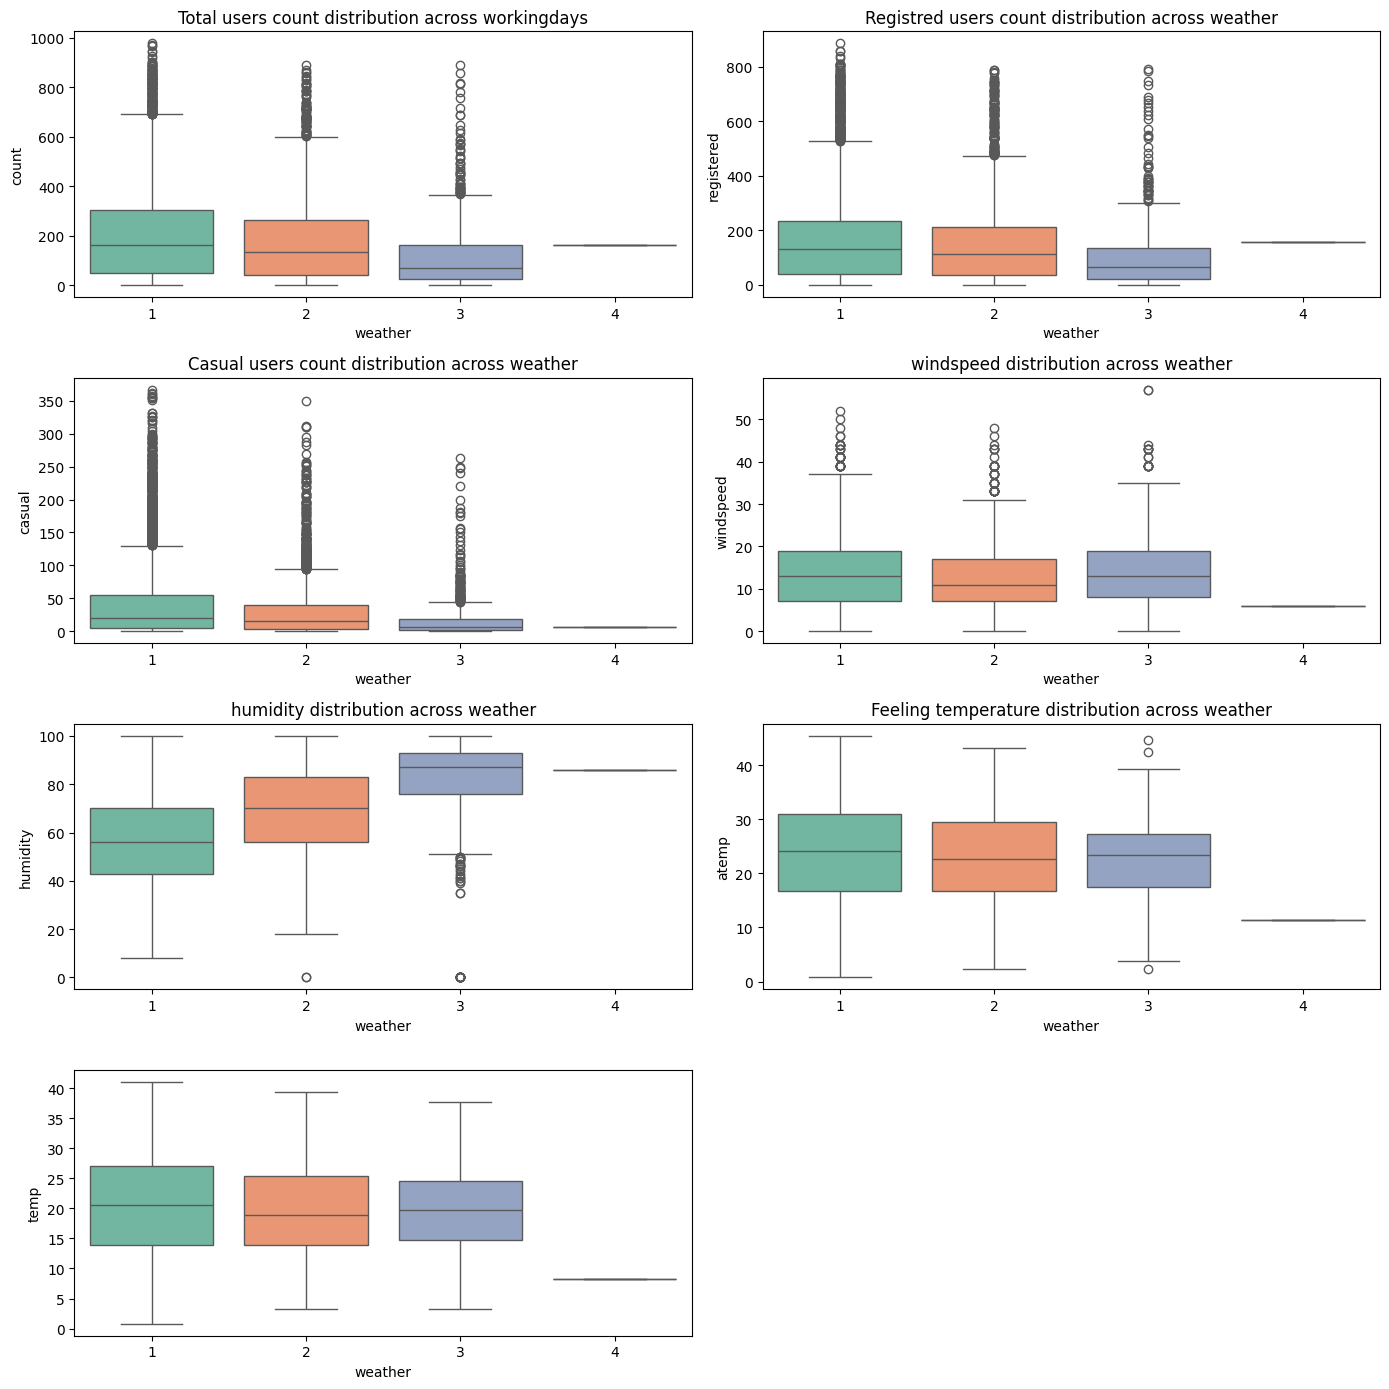

In [ ]:
#Boxplot - To compare and understand the distribution of continuous variables across workingdays.

fig,axes = plt.subplots(4,2,figsize=(14,14))


sns.boxplot(data=df, x="weather",y='count',palette="Set2",ax = axes[0,0])
axes[0,0].set_title("Total users count distribution across workingdays")

sns.boxplot(data=df, x="weather",y='registered',palette="Set2",ax = axes[0,1])
axes[0,1].set_title("Registred users count distribution across weather")

sns.boxplot(data=df, x="weather",y='casual',palette="Set2",ax = axes[1,0])
axes[1,0].set_title("Casual users count distribution across weather")

sns.boxplot(data=df, x="weather",y='windspeed',palette="Set2",ax = axes[1,1])
axes[1,1].set_title("windspeed distribution across weather")

sns.boxplot(data=df, x="weather",y='humidity',palette="Set2",ax = axes[2,0])
axes[2,0].set_title("humidity distribution across weather")

sns.boxplot(data=df, x="weather",y='atemp',palette="Set2",ax = axes[2,1])
axes[2,1].set_title("Temperature across weather")

sns.boxplot(data=df, x="weather",y='temp',palette="Set2",ax = axes[3,0])
axes[2,1].set_title("Feeling temperature distribution across weather")

axes[3,1].axis('off')

plt.tight_layout()
plt.show()

**Uneven Distribution:** The data is not evenly spread across the temperature categories.

**Dominant Categories:** The vast majority of observations (over 75%) fall into the <font color=brown>'Mild' (10-20°C) and 'Warm' (20-30°C)</font> categories.

**Most Common Category:** The <font color=brown>''Warm'</font>  category is the single most frequent temperature range in the dataset, with over 4,000 observations. 'Mild' is a very close second.

**Less Common Extremes**: The 'Cold' (0-10°C) and 'Hot' (30-41°C) categories are much less common and have a similar, lower frequency (around 1,250 observations each).

**Implication:** This is great for our analysis. We have a very large and reliable sample size for the most common weather conditions ('Mild' and 'Warm'). We also have enough data (over 1,000 observations each) for the 'Cold' and 'Hot' categories to make meaningful comparisons.

1.  <font color=brown>Clear Drop in Demand as Weather Worsens</font>
This is the strongest finding. As the weather gets worse (from 1 to 3), demand from all user types drops significantly.

**count (Total Users):** Demand is highest for weather type 1 (Clear). It drops for type 2 (Mist) and then drops dramatically for type 3 (Light Rain/Snow). The median for type 3 is very low, and the whole box is squished, showing a consistent lack of demand in bad weather.

**registered and casual Users:** This pattern holds true for both user types. Bad weather appears to be a major deterrent for everyone.

2.  <font color=brown>Weather Type 4 is Unusable for Analysis</font>
For weather category 4 (Heavy Rain/Snow), there is no box, just a single flat line.

**Confirms Countplot**: This confirms our finding from the Distribution of weather countplot: there is almost no data for this category (likely just one or two data points).

**Conclusion**: We cannot draw any statistical conclusions about weather type 4. Our analysis will have to focus on types 1, 2, and 3.

3.  <font color=brown>Environmental Factors Validate the Categories</font>
The other plots help explain why demand drops and validate the weather categories.

**humidity:** This plot makes perfect sense. The median humidity increases as the weather goes from 1 (Clear) -> 2 (Mist) -> 3 (Light Rain).

**windspeed:** This is an interesting finding. The median windspeed also increases as the weather worsens. This suggests that the drop in rentals during weather=3 might be due to a combination of rain and higher winds.

**temp and atemp**: The temperatures are fairly similar across weather types 1, 2, and 3. This is a very useful insight. It means the drop in demand is likely due to the rain/mist/wind itself, not because the bad weather days were also significantly colder.

####**5.2.5 temp_category:**

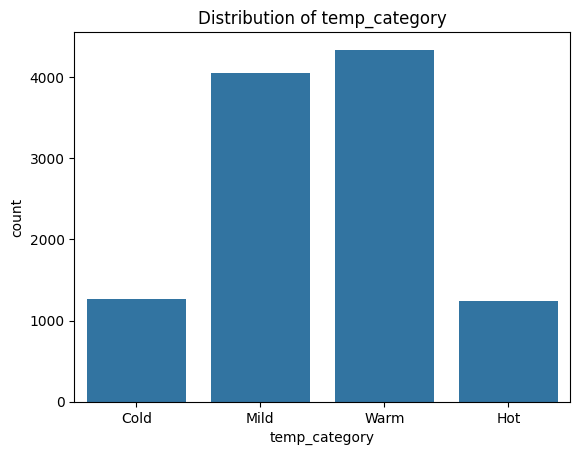

In [ ]:
#Countplot for temp_category distribution
sns.countplot(data=df,x="temp_category",order=['Cold', 'Mild', 'Warm', 'Hot'])
plt.title("Distribution of temp_category")
plt.show()

**Uneven Distribution:** The data is not evenly spread across the temperature categories.

**Dominant Categories:** The vast majority of observations (over 75%) fall into the <font color=brown>'Mild' (10-20°C) and 'Warm' (20-30°C)</font> categories.

**Most Common Category:** The <font color=brown>''Warm'</font>  category is the single most frequent temperature range in the dataset, with over 4,000 observations. 'Mild' is a very close second.

**Less Common Extremes**: The 'Cold' (0-10°C) and 'Hot' (30-41°C) categories are much less common and have a similar, lower frequency (around 1,250 observations each).

**Implication:** This is great for our analysis. We have a very large and reliable sample size for the most common weather conditions ('Mild' and 'Warm'). We also have enough data (over 1,000 observations each) for the 'Cold' and 'Hot' categories to make meaningful comparisons.

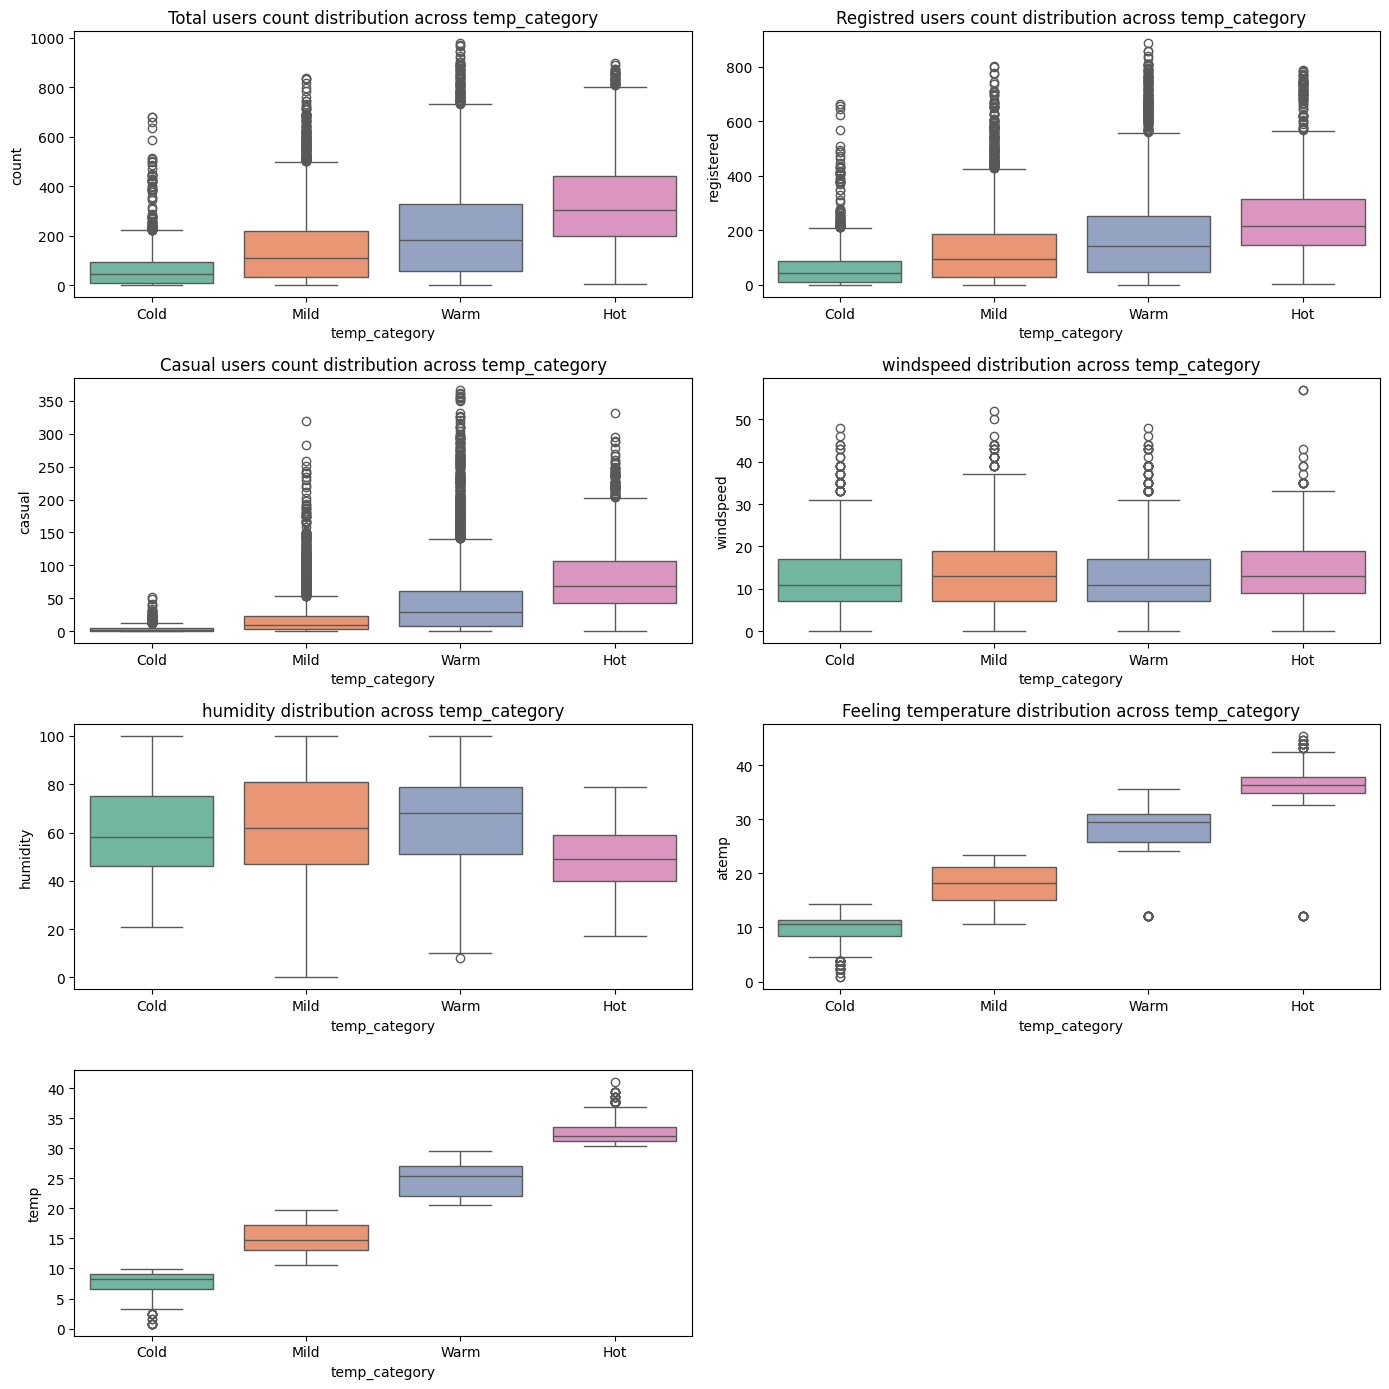

In [ ]:
#Boxplot - To compare and understand the distribution of continuous variables across temp_category.

fig,axes = plt.subplots(4,2,figsize=(14,14))


sns.boxplot(data=df, x="temp_category",y='count',palette="Set2",ax = axes[0,0])
axes[0,0].set_title("Total users count distribution across temp_category")

sns.boxplot(data=df, x="temp_category",y='registered',palette="Set2",ax = axes[0,1])
axes[0,1].set_title("Registred users count distribution across temp_category")

sns.boxplot(data=df, x="temp_category",y='casual',palette="Set2",ax = axes[1,0])
axes[1,0].set_title("Casual users count distribution across temp_category")

sns.boxplot(data=df, x="temp_category",y='windspeed',palette="Set2",ax = axes[1,1])
axes[1,1].set_title("windspeed distribution across temp_category")

sns.boxplot(data=df, x="temp_category",y='humidity',palette="Set2",ax = axes[2,0])
axes[2,0].set_title("humidity distribution across temp_category")

sns.boxplot(data=df, x="temp_category",y='atemp',palette="Set2",ax = axes[2,1])
axes[2,1].set_title("Temperature across temp_category")

sns.boxplot(data=df, x="temp_category",y='temp',palette="Set2",ax = axes[3,0])
axes[2,1].set_title("Feeling temperature distribution across temp_category")

axes[3,1].axis('off')


plt.tight_layout()
plt.show()

1. **The Main Demand Story: Hotter is Better**

Demand has a clear, positive relationship with temperature.

**'Cold' (0-10°C):** Has the lowest median demand (Total: 47.0).

**'Mild' (10-20°C):** Demand more than doubles (Total: 111.0).

**'Warm' (20-30°C):** Demand jumps again (Total: 181.0).

**'Hot' (30-41°C):** This is the peak demand category. (Total: 303.0).

<br>

2. **All User Types Agree**

Unlike other variables, there is no "commuter vs. leisure" split here. All user types follow the exact same pattern:

* **Registered Users:** Their demand steadily climbs and peaks at 'Hot' (Median: 215.0).

* **Casual Users:** Their demand also steadily climbs and peaks at 'Hot' (Median: 69.0).
<br>

3. **Key Environmental Insight (The Wind Chill Effect)**

The median windspeed is highest in the **'Mild'** and **'Hot'** categories and slightly lower in the **'Cold'** category.

This leads to a crucial insight:

* On 'Mild' or 'Hot' days, wind doesn't hurt rentals. It's likely perceived as refreshing.

* On 'Cold' days, however, you have a combination of low temperatures (0-10°C) and significant wind (median ~11). This "wind chill" effect is a powerful deterrent and is the key driver for the rock-bottom demand in this category.

**Final Business Insights**

* <font color=brown>'Heat is a Primary Driver:</font>  Yulu should expect and plan for its highest demand days to be on the hottest days. There is no "it's too hot to ride" effect.

* <font color=brown>"Cold + Wind" is a Primary Deterrent:</font> Yulu can confidently predict that demand will be extremely low on cold, windy days. This can help with bike maintenance scheduling and fleet management.

**Universal Driver:**

Because all user types (commuters and leisure) rent more in the heat, Yulu can simply increase fleet-wide bike deployment on hot days rather than worrying about specific zones.

####**5.2.6 atemp_category:**

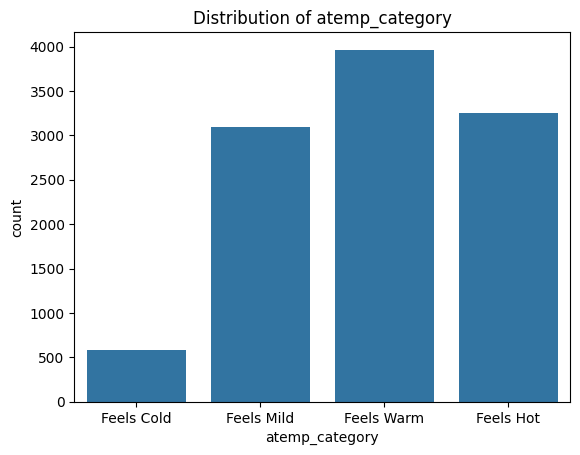

In [ ]:
#Countplot for atemp_category distribution
sns.countplot(data=df,x="atemp_category",order=['Feels Cold', 'Feels Mild', 'Feels Warm', 'Feels Hot'])
plt.title("Distribution of atemp_category")
plt.show()

**Most Common Operating Conditions**:

* The vast majority of Yulu's rentals (over 90%) occur when the weather feels 'Mild', 'Warm', or 'Hot'. This gives Yulu a very large and reliable dataset for analyzing user behavior in these typical conditions.

* <font color=brown> 'Feels Warm' is the "Norm":</font> The single most frequent category is 'Feels Warm' (20-30°C). This can be considered the baseline or "normal" environment for Yulu's operations.


* <font color=brown> 'Feels Cold' is a Rare Event:</font> Conditions that 'Feels Cold' (0-10°C) are very rare in the dataset. This is a key analytical insight: while you can still analyze this category, any conclusions about user demand in cold weather will be based on a much smaller sample size and should be treated with caution

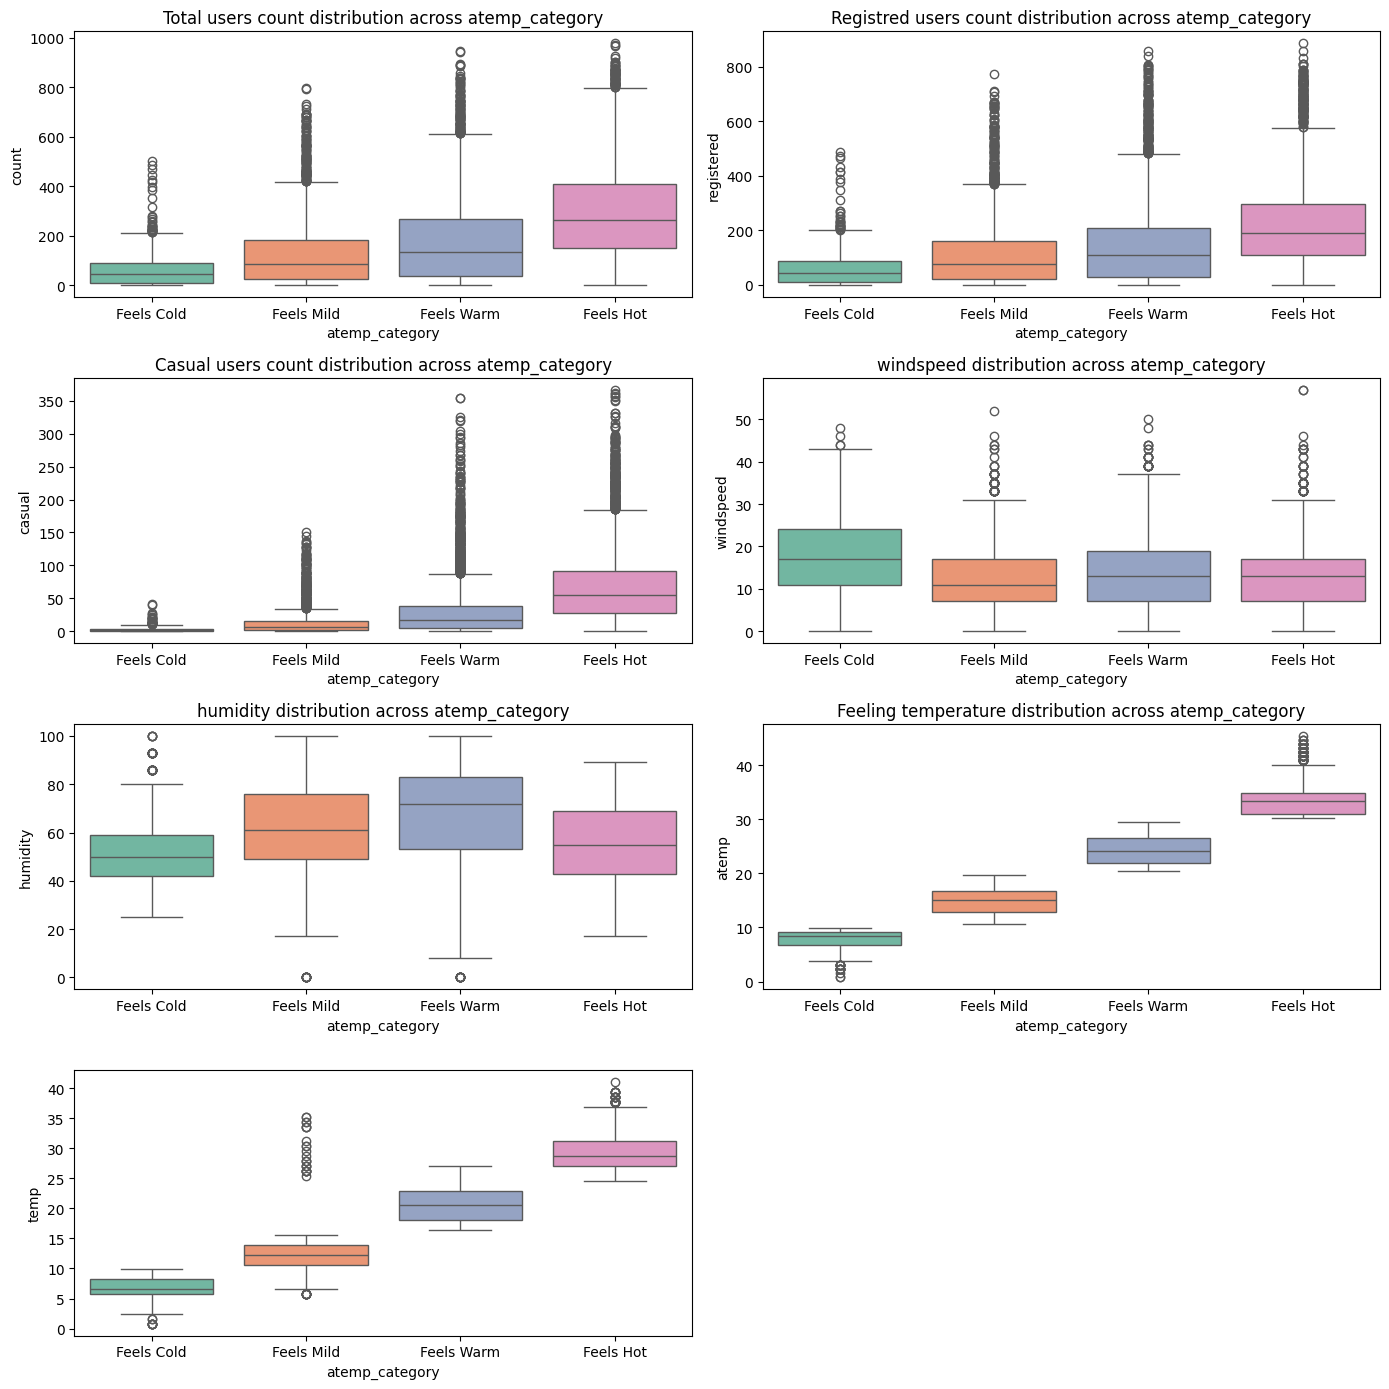

In [ ]:
#Boxplot - To compare and understand the distribution of continuous variables across atemp_category.

fig,axes = plt.subplots(4,2,figsize=(14,14))


sns.boxplot(data=df, x="atemp_category",y='count',palette="Set2",ax = axes[0,0])
axes[0,0].set_title("Total users count distribution across atemp_category")

sns.boxplot(data=df, x="atemp_category",y='registered',palette="Set2",ax = axes[0,1])
axes[0,1].set_title("Registred users count distribution across atemp_category")

sns.boxplot(data=df, x="atemp_category",y='casual',palette="Set2",ax = axes[1,0])
axes[1,0].set_title("Casual users count distribution across atemp_category")

sns.boxplot(data=df, x="atemp_category",y='windspeed',palette="Set2",ax = axes[1,1])
axes[1,1].set_title("windspeed distribution across atemp_category")

sns.boxplot(data=df, x="atemp_category",y='humidity',palette="Set2",ax = axes[2,0])
axes[2,0].set_title("humidity distribution across atemp_category")

sns.boxplot(data=df, x="atemp_category",y='atemp',palette="Set2",ax = axes[2,1])
axes[2,1].set_title("Temperature across atemp_category")

sns.boxplot(data=df, x="atemp_category",y='temp',palette="Set2",ax = axes[3,0])
axes[2,1].set_title("Feeling temperature distribution across atemp_category")

axes[3,1].axis('off')


plt.tight_layout()
plt.show()

These plots strongly confirm the insights from your temp_category analysis, showing that what a user feels is a powerful driver of demand.

1. **The Main Demand Story: Hotter Feels Better**
There is a clear and consistent positive relationship: as the "feeling" temperature increases, rental demand from all user types increases.

* <font color=brown> 'Feels Cold' (0-10°C):</font> Demand is at its absolute lowest for count, registered, and casual users.

* <font color=brown> 'Feels Mild' (10-20°C):</font> Demand increases significantly.

* <font color=brown> 'Feels Warm' (20-30°C):</font> Demand increases again.

* <font color=brown> 'Feels Hot' (30-46°C):</font> This is the peak demand category. The median rental count is highest across the board in this group. This confirms that even very hot-feeling weather is good for business.

2. **The "Wind Chill" Effect is Very Clear**

This is a crucial environmental insight.

* Look at the windspeed plot. The 'Feels Cold' category has the highest median windspeed and the largest spread (tallest box).

* This shows that the "coldest" periods are not just cold, they are also the windiest. This combination (the "wind chill" effect) is a powerful deterrent that drives demand to its lowest point.

3. **Sanity Check: Binning is Correct**

The plots for atemp vs. atemp_category and temp vs. atemp_category serve as a perfect sanity check.

They show four distinct, non-overlapping, and correctly ordered groups. The actual temperature (temp) rises in perfect sync with the "feeling" temperature (atemp).

####**5.2.8 humidity_category:**

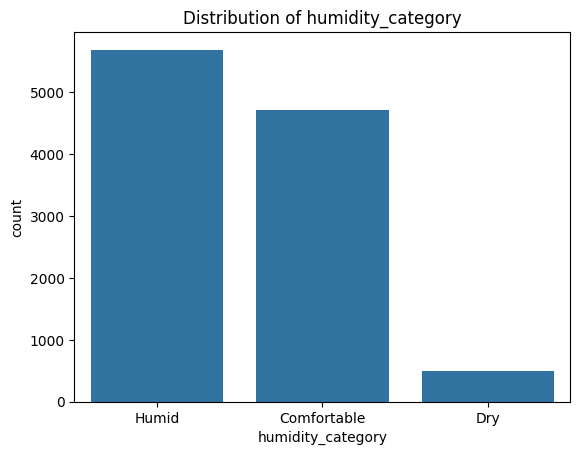

In [ ]:
#Countplot for humidity_category distribution
sns.countplot(data=df,x="humidity_category",order=['Humid', 'Comfortable', 'Dry'])
plt.title("Distribution of humidity_category")
plt.show()

* **Dominant Condition:** The most frequent condition in the dataset is 'Humid' (60-100%), with over 5,500 observations.

* **Common Condition:** The 'Comfortable' category (30-60%) is also very common, representing the second-largest group with over 4,500 observations.

* **Rare Condition:** 'Dry' conditions (0-30%) are very rare in the dataset, accounting for only about 500 observations.

**Business Insight:** Yulu's operations, as captured by this data, predominantly occur in 'Humid' or 'Comfortable' environments. This is great for analysis, as you have large, reliable sample sizes for these two main categories. Any conclusions about the 'Dry' category's effect on rentals will be based on a much smaller amount of data.

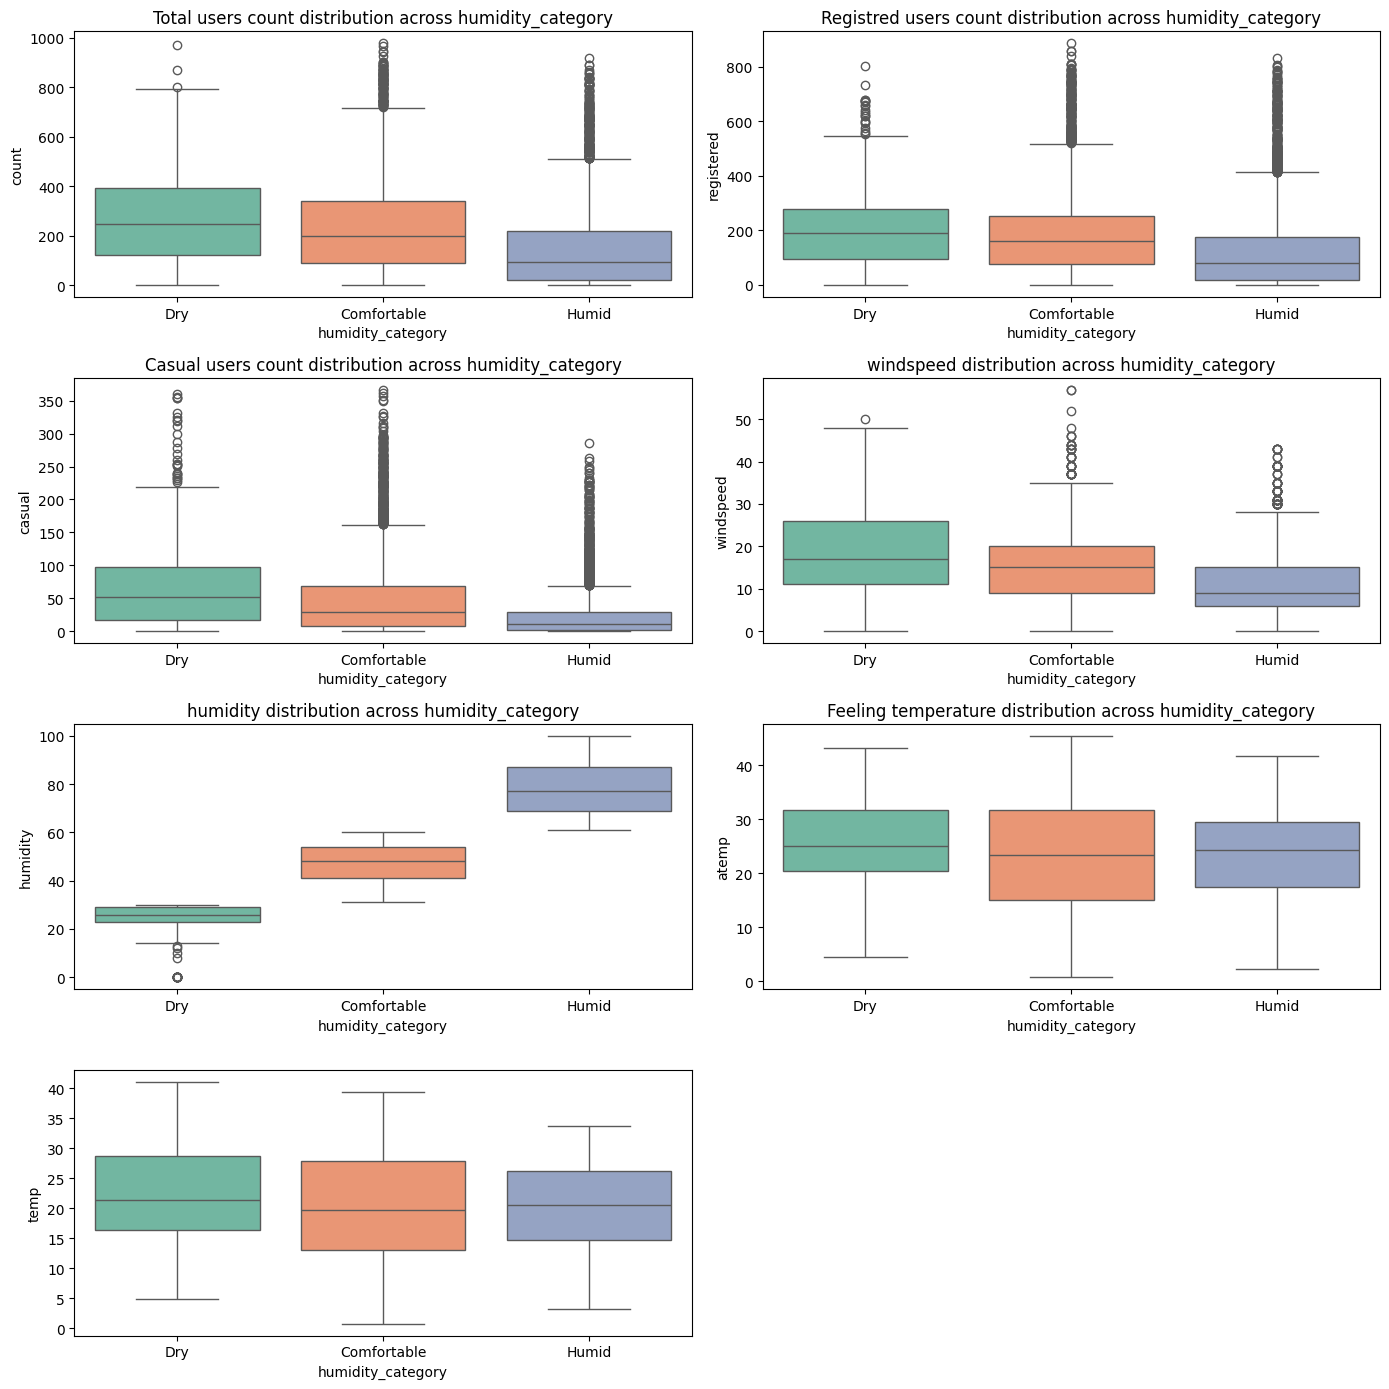

In [ ]:
#Boxplot - To compare and understand the distribution of continuous variables across humidity_category.

fig,axes = plt.subplots(4,2,figsize=(14,14))


sns.boxplot(data=df, x="humidity_category",y='count',palette="Set2",ax = axes[0,0])
axes[0,0].set_title("Total users count distribution across humidity_category")

sns.boxplot(data=df, x="humidity_category",y='registered',palette="Set2",ax = axes[0,1])
axes[0,1].set_title("Registred users count distribution across humidity_category")

sns.boxplot(data=df, x="humidity_category",y='casual',palette="Set2",ax = axes[1,0])
axes[1,0].set_title("Casual users count distribution across humidity_category")

sns.boxplot(data=df, x="humidity_category",y='windspeed',palette="Set2",ax = axes[1,1])
axes[1,1].set_title("windspeed distribution across humidity_category")

sns.boxplot(data=df, x="humidity_category",y='humidity',palette="Set2",ax = axes[2,0])
axes[2,0].set_title("humidity distribution across humidity_category")

sns.boxplot(data=df, x="humidity_category",y='atemp',palette="Set2",ax = axes[2,1])
axes[2,1].set_title("Temperature across humidity_category")

sns.boxplot(data=df, x="humidity_category",y='temp',palette="Set2",ax = axes[3,0])
axes[2,1].set_title("Feeling temperature distribution across humidity_category")

axes[3,1].axis('off')


plt.tight_layout()
plt.show()

1. **The Main Demand Story: Higher Humidity Seems to Reduce Rentals**

Looking at the top three plots, there is a <font color=brown>clear negative trend:</font> as humidity increases, rental demand tends to decrease.

* **count (Total Users):** Demand is highest in <font color=brown>
'Dry'</font> conditions. It drops slightly in 'Comfortable' conditions and drops again, to its lowest point, in 'Humid' conditions.

* **registered & casual Users:** Both user types follow this exact same pattern. This suggests that high humidity is a universal deterrent for both commuters and leisure riders.

2. **A Key Confounding Factor: Humidity vs. Temperature**

We cannot conclude that humidity alone is the cause. The temperature plots show that humidity is strongly linked to temperature:

* The 'Dry' (high demand) days are also the coolest (lowest median atemp).

* The 'Humid' (low demand) days are also the hottest (highest median atemp).

This creates a more complex picture: The drop in rentals on 'Humid' days might be due to the combined effect of high heat AND high humidity, which people find uncomfortable.

3. **Windspeed Insight**

This is another interesting confounding variable:

* The 'Dry' (high demand, cool temp) days are also the windiest (highest median windspeed).

* This suggests that on a cool day, high wind is not a deterrent. It may be that the 'Dry' category captures cool, windy, clear days that are perfect for riding.

4. **Sanity Check**

The humidity vs. humidity_category plot serves as a perfect "sanity check," showing three distinct, non-overlapping boxes.

####**5.2.9 windspeed_category:**

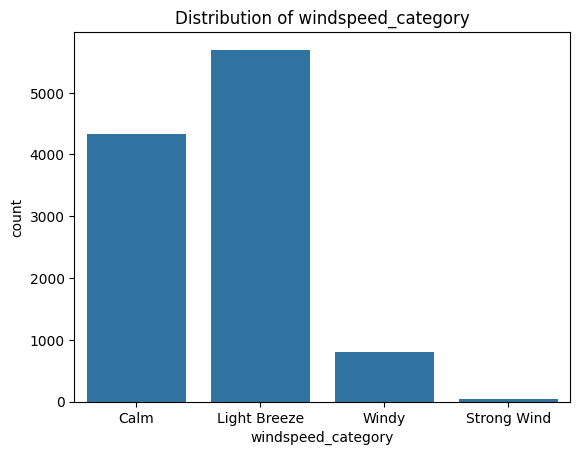

In [ ]:
#Countplot for windspeed_category distribution
sns.countplot(data=df,x="windspeed_category",order=['Calm', 'Light Breeze', 'Windy', 'Strong Wind'])
plt.title("Distribution of windspeed_category")
plt.show()

**Dominant Conditions:** The data is heavily concentrated in low-wind conditions. The vast majority of observations (over 9,500, or about 88%) fall into either the 'Calm' (0-10) or 'Light Breeze' (10-25) categories.

**Most Common Category:** <font color=brown>'Light Breeze'</font>
 is the single most frequent wind condition in the dataset, with over 5,500 observations. 'Calm' is a very close second, with over 4,000.

**Rare Conditions:** <font color=brown>Higher wind speeds are uncommon.</font> The 'Windy' category (25-40) is rare (under 1,000 observations), and the 'Strong Wind' category (40-57) is extremely rare, representing a tiny fraction of the data.

**Business Insight:** Yulu's operations are almost exclusively run in calm or lightly breezy conditions. This is great for analysis, as you have robust data for these common scenarios. However, you have very little data to analyze the impact of 'Windy' conditions and practically no data for 'Strong Wind', so it will be difficult to draw firm conclusions about how high wind affects rentals.



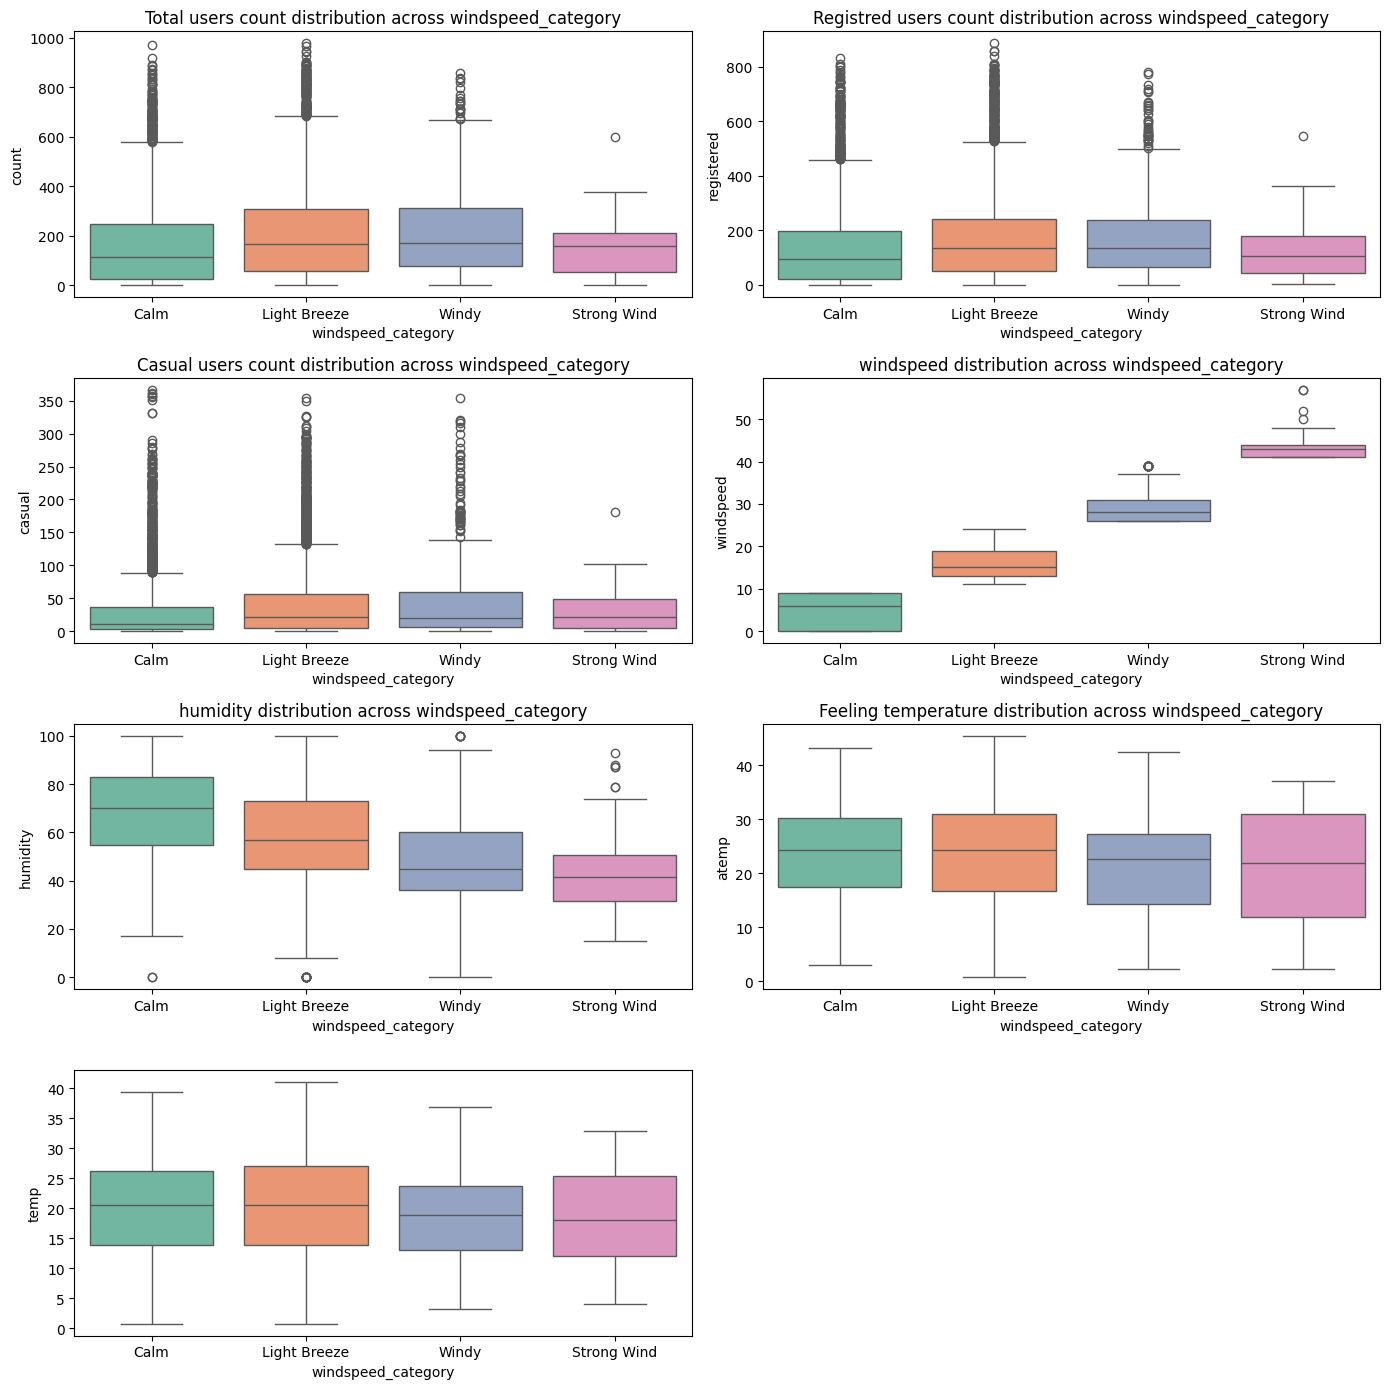

In [ ]:
#Boxplot - To compare and understand the distribution of continuous variables across windspeed_category.

fig,axes = plt.subplots(4,2,figsize=(14,14))


sns.boxplot(data=df, x="windspeed_category",y='count',palette="Set2",ax = axes[0,0])
axes[0,0].set_title("Total users count distribution across windspeed_category")

sns.boxplot(data=df, x="windspeed_category",y='registered',palette="Set2",ax = axes[0,1])
axes[0,1].set_title("Registred users count distribution across windspeed_category")

sns.boxplot(data=df, x="windspeed_category",y='casual',palette="Set2",ax = axes[1,0])
axes[1,0].set_title("Casual users count distribution across windspeed_category")

sns.boxplot(data=df, x="windspeed_category",y='windspeed',palette="Set2",ax = axes[1,1])
axes[1,1].set_title("windspeed distribution across windspeed_category")

sns.boxplot(data=df, x="windspeed_category",y='humidity',palette="Set2",ax = axes[2,0])
axes[2,0].set_title("humidity distribution across windspeed_category")

sns.boxplot(data=df, x="windspeed_category",y='atemp',palette="Set2",ax = axes[2,1])
axes[2,1].set_title("Temperature across windspeed_category")

sns.boxplot(data=df, x="windspeed_category",y='temp',palette="Set2",ax = axes[3,0])
axes[2,1].set_title("Feeling temperature distribution across windspeed_category")

axes[3,1].axis('off')


plt.tight_layout()
plt.show()

1. **The Main Demand Story: 'Calm' Weather is a Deterrent**

* <font color=brown>'Calm' (0-10):</font> This is the lowest demand category for all user types. (Total Median: 113.0)

* <font color=brown>'Light Breeze' (10-25):</font>  Demand jumps significantly. (Total Median: 165.0)

* <font color=brown>''Windy' (25-40):</font>  This is the peak demand category for total users. (Total Median: 168.0)

* <font color=brown>''Strong Wind' (40-57):</font>  Demand drops slightly from its peak, but is still far higher than on 'Calm' days. (Total Median: 157.5)


**2. What's Really Happening? (The Humidity Effect)**

* <font color=brown>'atemp vs. windspeed_category:</font>  The 'Calm', 'Light Breeze', and 'Windy' categories all have roughly the same median temperature.

* <font color=brown>'humidity vs. windspeed_category:</font>  This is the key. The 'Calm' category has the highest median humidity.


**Business Insight:**
* <font color=brown>'wind is good for business.</font> The worst condition for rentals is 'Calm' (no wind), likely because these periods are associated with high humidity, making the air feel stagnant and uncomfortable. A 'Light Breeze' or even 'Windy' day helps to lower the perceived humidity, making it feel more pleasant and driving demand up.

## **6. For Correlation (between continuous variables)**

###**6.1 temp', 'atemp', 'humidity', 'windspeed', Vs  'casual', 'registered', 'count'**

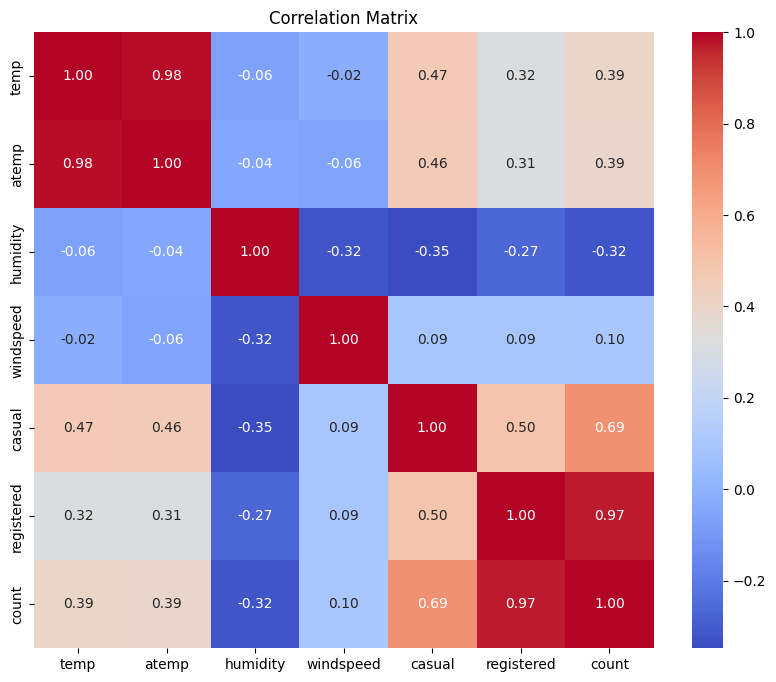

In [ ]:
 #1. Selected only the numerically encoded columns for the analysis
# Select only the continuous numerical columns
continuous_vars = ['temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count']
corr_matrix = df[continuous_vars].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()



1. **The Strongest Predictors of Total Demand (count)**
This confirms what your boxplots showed:

* <font color=brown> temp / atemp (0.39)</font>: There is a moderate positive correlation. This confirms our final boxplot analysis: as temperature increases, total rentals increase.

* <font color=brown>humidity (-0.32):</font> There is a moderate negative correlation. This confirms our corrected insight: as humidity increases, total rentals decrease.

* <font color=brown>windspeed (0.10):</font> There is a very weak positive correlation. This supports our final boxplot finding that wind is not a deterrent and may even be slightly beneficial.

2. The Most Important Business Insight: **Casual vs. Registered**
This is the most valuable story in the chart. The two user types react to weather very differently.

* <font color=purple>casual users are highly weather-sensitive</font>: casual has a strong positive link with temp (0.47) and a strong negative link with humidity (-0.35).

* <font color=purple>registered users are less weather-sensitive</font>: registered has a weaker positive link with temp (0.32) and a weaker negative link with humidity (-0.27).

**The Insight:** Casual (leisure) riders are much more influenced by the weather than registered (commuter) riders. A commuter will likely ride even if it's a bit humid or cool, but a casual rider is only going out for fun if the weather is great.

3. **A Critical Technical Finding: Multicollinearity**

* The correlation between temp and atemp is 0.98.

**The Insight:** These two variables are nearly identical. For any future predictive modeling, you must drop one of them (e.g., drop atemp) to prevent a statistical issue called multicollinearity.

4. **The windspeed vs. humidity Riddle**
There is a <font color=purple>moderate negative correlation</font> between humidity and windspeed (-0.32).

**The Insight**: This numerically confirms our final theory from the windspeed_category boxplots! It shows that periods of low wind ('Calm') are positively correlated with periods of high humidity. This explains why 'Calm' days had low rentals—they were also unpleasantly humid.

## **7. Outliers Analysis**

In [ ]:
# Define a function to summarize outliers using the 1.5*IQR rule
def outlier_summary(df, group_col, value_cols, return_outlier_rows=False):

    # Lists to store results
    records = []
    outliers_dict = {}

    # Group the DataFrame
    grouped = df.groupby(group_col, observed=False)

    # Loop through each group
    for gval, sub in grouped:
        n = len(sub)  # Get group size

        # Skip empty groups
        if n == 0:
            continue

        # Loop through each column to check for outliers
        for col in value_cols:
            # Check if column exists
            if col not in sub.columns:
                raise KeyError(f"{col} not in dataframe")

            # Get the data and drop missing values
            ser = sub[col].dropna()

            # Handle empty series
            if ser.empty:
                q1 = q3 = iqr = lower = upper = np.nan
                out_cnt = 0
            else:
                # Calculate quartiles and IQR
                q1 = ser.quantile(0.25)
                q3 = ser.quantile(0.75)
                iqr = q3 - q1

                # Define outlier bounds
                lower = q1 - 1.5 * iqr
                upper = q3 + 1.5 * iqr

                # Find outliers
                is_out = (ser < lower) | (ser > upper)
                out_cnt = int(is_out.sum()) # Count outliers

            # Calculate outlier percentage
            out_pct = (out_cnt / n) * 100 if n > 0 else 0.0

            # Store the summary results
            records.append({
                "group_col": group_col,
                "group_value": gval,
                "col": col,
                "n": n,
                "q1": q1,
                "q3": q3,
                "iqr": iqr,
                "lower": lower,
                "upper": upper,
                "outlier_count": out_cnt,
                "outlier_pct": out_pct
            })

            # Store the actual outlier rows if requested
            if return_outlier_rows:
                outliers_dict[(gval, col)] = sub.loc[is_out.index[is_out].tolist()] if out_cnt > 0 else sub.iloc[0:0]

    # Convert results list to a DataFrame
    summary_df = pd.DataFrame.from_records(records,
                                            columns=["group_col","group_value","col","n","q1","q3","iqr","lower","upper","outlier_count","outlier_pct"])

    # Sort the final DataFrame
    summary_df = summary_df.sort_values(["col","group_value"]).reset_index(drop=True)

    # Return summary and (optionally) outlier rows
    if return_outlier_rows:
        return summary_df, outliers_dict
    return summary_df

### **7.1 Outlier Detection**

#### **7.1.1 season level**

In [ ]:
# Outliers for season
summary_season = outlier_summary(df, group_col="season", value_cols=["registered",'count','casual'])
display(summary_season)

,group_col,group_value,col,n,q1,q3,iqr,lower,upper,outlier_count,outlier_pct
0,season,1,casual,2686,1.0,15.00,14.00,-20.000,36.000,278,10.349963
1,season,2,casual,2733,8.0,63.00,55.00,-74.500,145.500,187,6.842298
2,season,3,casual,2733,10.0,74.00,64.00,-86.000,170.000,141,5.159166
3,season,4,casual,2734,4.0,33.00,29.00,-39.500,76.500,247,9.034382
4,season,1,count,2686,24.0,164.00,140.00,-186.000,374.000,139,5.174981
5,season,2,count,2733,49.0,321.00,272.00,-359.000,729.000,42,1.536773
6,season,3,count,2733,68.0,347.00,279.00,-350.500,765.500,61,2.231980
7,season,4,count,2734,51.0,294.00,243.00,-313.500,658.500,64,2.340892
8,season,1,registered,2686,22.0,141.00,119.00,-156.500,319.500,123,4.579300
9,season,2,registered,2733,39.0,243.00,204.00,-267.000,549.000,103,3.768752


#### **7.1.2 holiday level**

In [ ]:
# Outliers for holiday
summary_holiday = outlier_summary(df, group_col="holiday", value_cols=["registered",'count','casual'])
display(summary_holiday)

,group_col,group_value,col,n,q1,q3,iqr,lower,upper,outlier_count,outlier_pct
0,holiday,0,casual,10575,4.0,48.0,44.0,-62.00,114.00,721,6.817967
1,holiday,1,casual,311,5.0,70.5,65.5,-93.25,168.75,21,6.752412
2,holiday,0,count,10575,43.0,283.0,240.0,-317.00,643.00,311,2.940898
3,holiday,1,count,311,38.5,308.0,269.5,-365.75,712.25,0,0.000000
4,holiday,0,registered,10575,36.0,223.0,187.0,-244.50,503.50,416,3.933806
5,holiday,1,registered,311,30.0,207.0,177.0,-235.50,472.50,6,1.929260


#### **7.1.3 workingday level**

In [ ]:
# Outliers for workingday
summary_workingday= outlier_summary(df, group_col="workingday", value_cols=["registered",'count','casual'])
display(summary_workingday)

,group_col,group_value,col,n,q1,q3,iqr,lower,upper,outlier_count,outlier_pct
0,workingday,0,casual,3474,6.0,90.0,84.0,-120.0,216.0,189,5.440415
1,workingday,1,casual,7412,3.0,39.0,36.0,-51.0,93.0,254,3.426875
2,workingday,0,count,3474,44.0,304.0,260.0,-346.0,694.0,16,0.460564
3,workingday,1,count,7412,41.0,277.0,236.0,-313.0,631.0,278,3.750675
4,workingday,0,registered,3474,36.0,207.0,171.0,-220.5,463.5,11,0.316638
5,workingday,1,registered,7412,36.0,233.0,197.0,-259.5,528.5,364,4.910955


#### **7.1.4 weather level**

In [ ]:
# Outliers for weather
summary_Stay_In_Current_City_Years = outlier_summary(df, group_col="weather", value_cols=["registered",'count','casual'])
display(summary_Stay_In_Current_City_Years)

,group_col,group_value,col,n,q1,q3,iqr,lower,upper,outlier_count,outlier_pct
0,weather,1,casual,7192,5.0,55.0,50.0,-70.00,130.00,494,6.868743
1,weather,2,casual,2834,4.0,40.0,36.0,-50.00,94.00,208,7.339450
2,weather,3,casual,859,1.0,18.5,17.5,-25.25,44.75,96,11.175786
3,weather,4,casual,1,6.0,6.0,0.0,6.00,6.00,0,0.000000
4,weather,1,count,7192,48.0,305.0,257.0,-337.50,690.50,160,2.224694
5,weather,2,count,2834,41.0,264.0,223.0,-293.50,598.50,82,2.893437
6,weather,3,count,859,23.0,161.0,138.0,-184.00,368.00,56,6.519208
7,weather,4,count,1,164.0,164.0,0.0,164.00,164.00,0,0.000000
8,weather,1,registered,7192,41.0,236.0,195.0,-251.50,528.50,266,3.698554
9,weather,2,registered,2834,35.0,211.0,176.0,-229.00,475.00,115,4.057869


#### **7.1.5 temp_category level**


In [ ]:
# Outliers for temp_category
summary_marital = outlier_summary(df, group_col="temp_category", value_cols=["registered",'count','casual'])
display(summary_marital)

,group_col,group_value,col,n,q1,q3,iqr,lower,upper,outlier_count,outlier_pct
0,temp_category,Cold,casual,1259,0.00,5.00,5.0,-7.5,12.5,83,6.592534
1,temp_category,Hot,casual,1244,43.00,107.00,64.0,-53.0,203.0,72,5.787781
2,temp_category,Mild,casual,4049,3.00,23.00,20.0,-27.0,53.0,350,8.644110
3,temp_category,Warm,casual,4334,8.00,61.00,53.0,-71.5,140.5,293,6.760498
4,temp_category,Cold,count,1259,10.00,95.00,85.0,-117.5,222.5,82,6.513106
5,temp_category,Hot,count,1244,198.00,441.00,243.0,-166.5,805.5,35,2.813505
6,temp_category,Mild,count,4049,33.00,220.00,187.0,-247.5,500.5,140,3.457644
7,temp_category,Warm,count,4334,58.00,328.00,270.0,-347.0,733.0,87,2.007383
8,temp_category,Cold,registered,1259,9.00,89.00,80.0,-111.0,209.0,84,6.671962
9,temp_category,Hot,registered,1244,147.75,315.25,167.5,-103.5,566.5,69,5.546624


#### **7.1.6 atemp_category level**

In [ ]:
# Outliers for temp_category
summary_Stay_In_Current_City_Years = outlier_summary(df, group_col="atemp_category", value_cols=["registered",'count','casual'])
display(summary_Stay_In_Current_City_Years)

,group_col,group_value,col,n,q1,q3,iqr,lower,upper,outlier_count,outlier_pct
0,atemp_category,Feels Cold,casual,577,0.0,4.00,4.00,-6.000,10.000,30,5.199307
1,atemp_category,Feels Hot,casual,3250,28.0,90.75,62.75,-66.125,184.875,236,7.261538
2,atemp_category,Feels Mild,casual,3095,2.0,15.00,13.00,-17.500,34.500,242,7.819063
3,atemp_category,Feels Warm,casual,3964,5.0,38.00,33.00,-44.500,87.500,319,8.047427
4,atemp_category,Feels Cold,count,577,10.0,91.00,81.00,-111.500,212.500,33,5.719237
5,atemp_category,Feels Hot,count,3250,150.0,408.75,258.75,-238.125,796.875,69,2.123077
6,atemp_category,Feels Mild,count,3095,23.0,181.00,158.00,-214.000,418.000,118,3.812601
7,atemp_category,Feels Warm,count,3964,37.0,267.00,230.00,-308.000,612.000,107,2.699294
8,atemp_category,Feels Cold,registered,577,9.0,86.00,77.00,-106.500,201.500,33,5.719237
9,atemp_category,Feels Hot,registered,3250,110.0,297.00,187.00,-170.500,577.500,155,4.769231


#### **7.1.7 humidity_category level**

In [ ]:
# Outliers for humidity_category
summary_humidity_category = outlier_summary(df, group_col="humidity_category", value_cols=["registered",'count','casual'])
display(summary_humidity_category)

,group_col,group_value,col,n,q1,q3,iqr,lower,upper,outlier_count,outlier_pct
0,humidity_category,Comfortable,casual,4710,7.00,68.75,61.75,-85.625,161.375,294,6.242038
1,humidity_category,Dry,casual,492,16.00,98.00,82.00,-107.000,221.000,26,5.284553
2,humidity_category,Humid,casual,5684,2.00,29.00,27.00,-38.500,69.500,432,7.600281
3,humidity_category,Comfortable,count,4710,89.00,339.75,250.75,-287.125,715.875,105,2.229299
4,humidity_category,Dry,count,492,123.00,392.00,269.00,-280.500,795.500,3,0.609756
5,humidity_category,Humid,count,5684,21.00,217.00,196.00,-273.000,511.000,225,3.958480
6,humidity_category,Comfortable,registered,4710,77.00,254.00,177.00,-188.500,519.500,208,4.416136
7,humidity_category,Dry,registered,492,94.75,277.25,182.50,-179.000,551.000,21,4.268293
8,humidity_category,Humid,registered,5684,18.00,176.00,158.00,-219.000,413.000,297,5.225194


#### **7.1.8 windspeed_category level**

In [ ]:
#Outliers for windspeed_category
summary_windspeed_category = outlier_summary(df, group_col="windspeed_category", value_cols=["registered",'count','casual'])
display(summary_windspeed_category)

,group_col,group_value,col,n,q1,q3,iqr,lower,upper,outlier_count,outlier_pct
0,windspeed_category,Calm,casual,4339,3.00,37.00,34.00,-48.000,88.000,344,7.928094
1,windspeed_category,Light Breeze,casual,5698,5.00,56.00,51.00,-71.500,132.500,358,6.282906
2,windspeed_category,Strong Wind,casual,40,4.50,48.50,44.00,-61.500,114.500,1,2.500000
3,windspeed_category,Windy,casual,809,6.00,60.00,54.00,-75.000,141.000,52,6.427689
4,windspeed_category,Calm,count,4339,26.00,247.00,221.00,-305.500,578.500,146,3.364831
5,windspeed_category,Light Breeze,count,5698,58.00,308.00,250.00,-317.000,683.000,139,2.439452
6,windspeed_category,Strong Wind,count,40,53.25,212.00,158.75,-184.875,450.125,1,2.500000
7,windspeed_category,Windy,count,809,76.00,313.00,237.00,-279.500,668.500,19,2.348578
8,windspeed_category,Calm,registered,4339,22.00,197.00,175.00,-240.500,459.500,174,4.010141
9,windspeed_category,Light Breeze,registered,5698,49.00,240.00,191.00,-237.500,526.500,221,3.878554


1. **The Main Insight: Outliers Confirm the Data is Skewed (And We Must Keep Them)**

This is the most important takeaway. Every single table shows a significant percentage of "outliers" (often 2-10%) in almost every single category.

**This is Not a Data Error:** These are not bad data points. As we saw in our histograms, the count, casual, and registered variables are all **strongly right-skewed** (piled up on the left with a long tail to the right).

* These are our real, high-demand days—your best and most interesting data! Removing them would completely distort your analysis.

This outlier report is simply the numerical proof of what we saw visually: **our data is not normally distributed**. This is the main assumption we will report as "violated" when we start our hypothesis tests (which is perfectly fine and expected).

2. **Deeper Insights from Comparing Outlier Percentages**
We can find some new, more subtle insights by comparing the outlier_pct between groups.

**Insight 1: casual User Demand is More "Spiky"**

* The outlier_pct for casual in almost every table is consistently high: 10.3% in one season, 11.1% in weather=3, 7.9% in Calm wind.

**Business Insight:** This means the demand from **casual users is more variable and unpredictable** than from registered users. While the median casual use might be low, it's prone to sudden, unexpected spikes (high-outlier days). This makes sense: registered users are stable commuters, but casual users are driven by impulses, special events, or perfect weather.

**Insight 2: Holidays are "Consistently Busy" (Not "Spiky")**

* On non-holidays (group_value=0), there are 311 outliers (2.9% of the data).

* On **holidays** (group_value=1), there are 0 outliers **(0.0%)**!

**Business Insight:** This means that while holidays are busier (as our boxplots showed), the demand is very predictable. It's consistently high, but it stays within a stable range. You don't get "off-the-charts" super-high outlier days on a holiday; you just get a reliable, solid block of high demand.

**Insight 3: Small Sample Sizes**

* For weather=4 (Heavy Rain). The n is 1.

* For Strong Wind. The n is 40.

**Insight:** The outlier percentages for these groups (0% or 2.5%) are meaningless. The sample sizes are far too small to draw any conclusions, which confirms our earlier EDA.

**Why we Don't need Clip (for This Project)**

* Clipping (or "winsorizing") is a technique used in predictive modeling (like linear regression). The goal there is to prevent a single extreme value from having too much leverage and skewing the model's coefficients.But our goal is different. Our goal is hypothesis testing (t-test, ANOVA) to see if there is a real, statistically significant difference in the means between groups.

* Those "outliers" are real, high-demand days.

* Clipping them (e.g., changing a 977-rental day to 643) would be artificially distorting your data.

* You would be hiding the truth—that some days are genuinely, extremely busy. This would reduce the mean of your busy groups and might even cause you to miss a real, significant finding.

## **8. Dropping temperature field due to multicollinearity**

In [ ]:
# Dropping temperature field due to multicollinearity
df = df.drop('atemp', axis=1)
df

,datetime,season,holiday,workingday,weather,temp,temp_category,atemp_category,humidity,humidity_category,windspeed,windspeed_category,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,Cold,Feels Mild,81,Humid,0.0000,Calm,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,Cold,Feels Mild,80,Humid,0.0000,Calm,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,Cold,Feels Mild,80,Humid,0.0000,Calm,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,Cold,Feels Mild,75,Humid,0.0000,Calm,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,Cold,Feels Mild,75,Humid,0.0000,Calm,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,Mild,Feels Mild,50,Comfortable,26.0027,Windy,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,Mild,Feels Mild,57,Comfortable,15.0013,Light Breeze,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,Mild,Feels Mild,61,Humid,15.0013,Light Breeze,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,Mild,Feels Mild,61,Humid,6.0032,Calm,12,117,129


* Due to  Multicollinearity issue we should drop one of the temperature columns.
* It's good practice to clean the data now. You can drop atemp since temp is the raw measurement.

## **9. Check if there any significant difference between the no. of bike rides on Weekdays and Weekends?**

### **9.1 Formulation of Null and Alternater Hypotheses**

1. **H0​**:<font color='orange'>μworkingday​=μnon-workingday​</font>(The average count on working days is equal to the average count on non-working days.)
2. **Ha​:**:<font color='orange'>μworkingday​ $\neq$ μnon-workingday​​</font>(The average count on working days is not equal to the average count on non-working days.)This is a two-tailed test because we're just testing for any difference (not specifically if one is greater than the other).

### **9.2 Select an appropriate test**

* We can use a 2-Sample Independent T-test.

Because we are comparing the means of two independent groups (working days vs. non-working days) on a continuous variable (count).

### **9.3 Set a significance level ($\alpha$)**

* Significance Level ($\alpha$): **0.05**

### **9.4 Check Assumptions and Calculate test statistics/p-value**

#### **9.4.1 Check for normality and Homogeneity of variance**

* **Normality**: We can take Shapiro-Wilk Test


Shapiro_test value - non_workingday:4.4728547627911074e-45
Shapiro_test value - workingday:2.2521124830019574e-61
kurtosis:-1.3978278096729435
Skewness: -0.7761630216040661


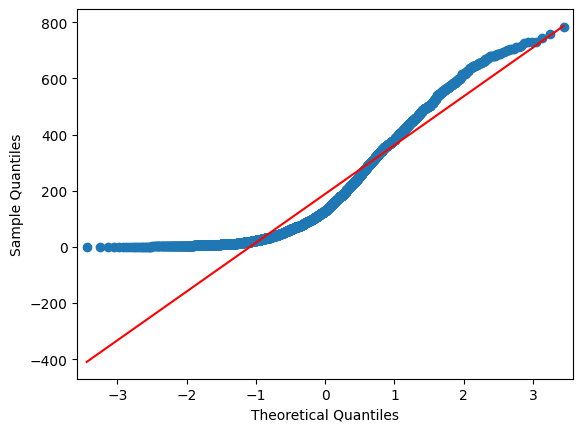

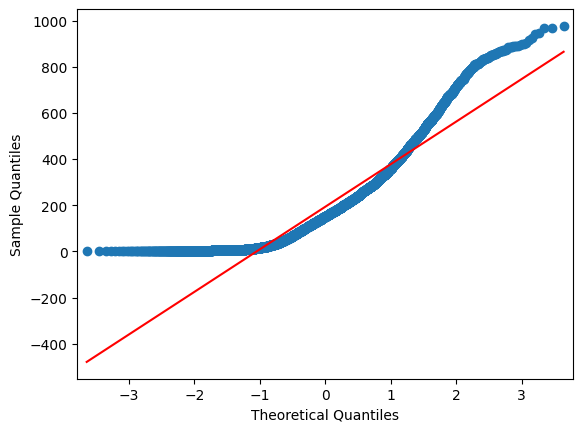

In [ ]:
import warnings
warnings.filterwarnings('ignore', message='scipy.stats.shapiro: For N > 5000')

non_workingday = df[df['workingday'] == '0']['count']
workingday = df[df['workingday'] == '1']['count']

##Shapiro-Test
test_stat1, p_value1 = shapiro(non_workingday)
test_stat2, p_value2 = shapiro(workingday)

print(f"Shapiro_test value - non_workingday:{p_value1}",
      f"Shapiro_test value - workingday:{p_value2}",
      sep='\n')

##Kurtosis and Skewness Test
print(f"kurtosis:{df['workingday'].astype('int').kurt()}",
      f"Skewness: {df['workingday'].astype('int').skew()}",
      sep='\n')

##Q-Q plot
fig_1 = sm.qqplot(non_workingday, line='s')
fig_2 = sm.qqplot(workingday, line='s')


This confirms that the normality assumption is violated.



 * **Homogeneity of Variance (Equal Variances):** We can take Levene's test

In [ ]:
non_workingday = df[df['workingday'] == '0']['count']
workingday = df[df['workingday'] == '1']['count']

#Levene's test for variance
levene_stat1, p_value1 = levene(non_workingday,workingday)

p_value1

np.float64(0.9437823280916695)

**Conclusion:**

1. **Normality:** Failed. (The data is right-skewed, which is fine, we just report it).

2. **Equal Variances:** Passed. (Your Levene's test p-value was 0.94).

Since,our sample size is very large (N=3474 and N=7412), the t-test is considered "robust" to violations of normality due to Central Limit Theorem, which basically says that the distribution of the sample means will be normal, even if the data itself isn't.

#### **9.4.2 Run 2-Sample Independent T-test**

In [ ]:
non_workingday = df[df['workingday'] == '0']['count']
workingday = df[df['workingday'] == '1']['count']

#2-Sample T-test for working days
t_stat, pvalue = ttest_ind(non_workingday, workingday)
pvalue

np.float64(0.22644804226361348)

* p-value (0.2264) > $\alpha$ (0.05)Decision: We do not have sufficient evidence to reject the Null Hypothesis ($H_0$).

#### **9.4.3 Inferences,Conclusions and Recommendations**

**Statistical Inference:**
We failed to reject the Null Hypothesis ($H_0$). The p-value of 0.2264 is well above our 0.05 significance level. <font color=brown>This means there is no statistically significant difference in the average total count of bike rentals between working days and non-working days </font>. The small difference we saw in the medians (151 vs. 128) is likely due to random chance, not a real effect.

**Business Conclusion**: Yulu should not expect a significant difference in the overall demand for bikes on a weekday versus a weekend/holiday. Their plan for the total number of bikes to deploy can be consistent across all days.

The t-test only told us that the total count is the same.

But,Our EDA boxplots told us why:

* On working days: registered users are HIGH.

* On non-working days: casual users are HIGH.

These <font color=brown>two opposing effects cancel each other out, making the total count look the same</font>.

**Recommendation:**
"While the total number of bikes needed is the same (as per our t-test), the type of user is completely different. Yulu's marketing and bike-placement strategy should be radically different on working days (targeting commuters near offices) versus non-working days (targeting leisure riders near parks)."

## **10. Check if the demand of bicycles on rent is the same for different Weather conditions?**



### **10.1 Formulation of Null and Alternater Hypotheses**

* A statistical test like ANOVA or Levene's test can't run on a group with only one observation because it's impossible to calculate the group's variance (its spread) from a single point. It will break the test. So, our logical first step is to filter out that one row. Our ANOVA will be a comparison of the three meaningful weather groups: 1, 2, and 3.

1. **H0​**: <font color='orange'>μweather1​=μweather2​=μweather3​</font>​(The average count is the same across the first three weather types.)

2. **Ha​**: <font color='orange'>At least one of the group means is different.​​</font>(The average count for at least one weather type is different from the others.)


In [ ]:
#Filter out that one weather row
df_weather = df[df['weather'] != '4']
df_weather


,datetime,season,holiday,workingday,weather,temp,temp_category,atemp_category,humidity,humidity_category,windspeed,windspeed_category,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,Cold,Feels Mild,81,Humid,0.0000,Calm,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,Cold,Feels Mild,80,Humid,0.0000,Calm,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,Cold,Feels Mild,80,Humid,0.0000,Calm,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,Cold,Feels Mild,75,Humid,0.0000,Calm,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,Cold,Feels Mild,75,Humid,0.0000,Calm,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,Mild,Feels Mild,50,Comfortable,26.0027,Windy,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,Mild,Feels Mild,57,Comfortable,15.0013,Light Breeze,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,Mild,Feels Mild,61,Humid,15.0013,Light Breeze,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,Mild,Feels Mild,61,Humid,6.0032,Calm,12,117,129


### **10.2 Select an appropriate test**

* We can use an One-way ANOVA test.

Because we are comparing the means of more than 2 independent groups of a categorical variable (3 weathers) on a continuous variable (count).

### **10.3 Set a significance level ($\alpha$)**

* Significance Level ($\alpha$): **0.05**

### **10.4 Check Assumptions and Calculate test statistics/p-value**

#### **10.4.1 Check for normality and Homogeneity of variance**

* **Normality**: We can take Shapiro-Wilk Test


Shapiro_test value - weather_1:1.5964921477006555e-57
Shapiro_test value - weather_2:9.777839106111785e-43
Shapiro_test value - weather_3:3.875893017396149e-33
kurtosis:0.3820856460185107
Skewness: 1.2411764385668884


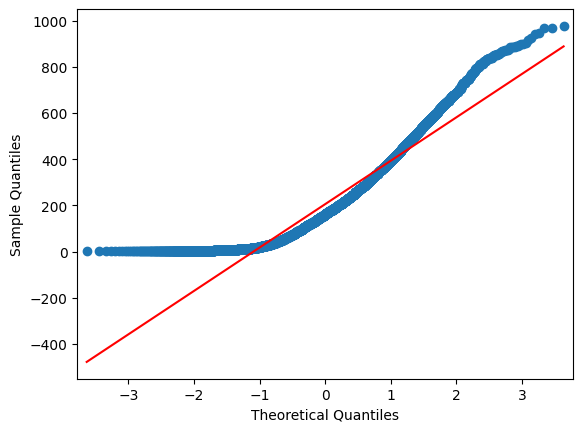

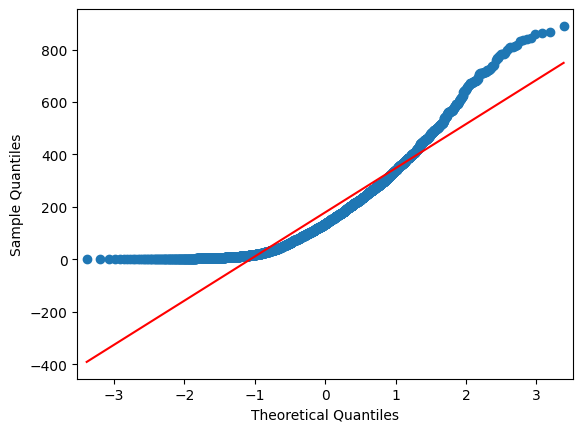

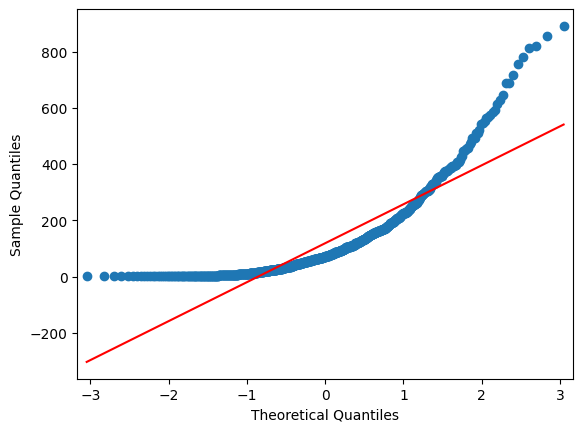

In [ ]:
import warnings
warnings.filterwarnings('ignore', message='scipy.stats.shapiro: For N > 5000')

weather_1 = df_weather[df_weather['weather'] == '1']['count']
weather_2 = df_weather[df_weather['weather'] == '2']['count']
weather_3 = df_weather[df_weather['weather'] == '3']['count']

##Shapiro-Test
test_stat1, p_value1 = shapiro(weather_1)
test_stat2, p_value2 = shapiro(weather_2)
test_stat2, p_value3 = shapiro(weather_3)

print(f"Shapiro_test value - weather_1:{p_value1}",
      f"Shapiro_test value - weather_2:{p_value2}",
      f"Shapiro_test value - weather_3:{p_value3}",
      sep='\n')

#Kurtosis and Skewness Test
print(f"kurtosis:{df_weather['weather'].astype('int').kurt()}",
      f"Skewness: {df_weather['weather'].astype('int').skew()}",
      sep='\n')

#Q-Q plot
fig_1 = sm.qqplot(weather_1, line='s')
fig_2 = sm.qqplot(weather_2, line='s')
fig_3 = sm.qqplot(weather_3, line='s')




* This confirms that the normality assumption is violated,the weather variable is not normally distributed,(i.e) It shows a noticeable positive skew (leaning left, tail to the right) and is slightly more peaked with heavier tails (leptokurtic) than a standard bell curve.



 * **Homogeneity of Variance (Equal Variances):** We can take Levene's test

In [ ]:
weather_1 = df_weather[df_weather['weather'] == '1']['count']
weather_2 = df_weather[df_weather['weather'] == '2']['count']
weather_3 = df_weather[df_weather['weather'] == '3']['count']

#Levene's test for cheking variances of weather
test_stat1, p_value1 = levene(weather_1,weather_2,weather_3)

p_value1


np.float64(6.198278710731511e-36)

**Conclusion:**

1. **Normality:** Failed.
2. **Equal Variances:** We reject the null hypothesis of Levene's test. This means the variances are not equal among the three weather groups. Our boxplots also showed this, as the "box" for weather=1 was much taller (more spread) than the one for weather=3.


#### **10.4.2 Run One way ANOVA test**

* Generally,If some assumptions fail (levene’s test or Shapiro-wilk test), we cannot the standard ANOVA test but it question it is mentioned to continue doing the analysisc if some assumptions fail even but double check using visual analysis and report wherever necessary

In [ ]:
weather_1 = df_weather[df_weather['weather'] == '1']['count']
weather_2 = df_weather[df_weather['weather'] == '2']['count']
weather_3 = df_weather[df_weather['weather'] == '3']['count']

#One-way test for checking significant relationship between weather
f_stats, p_value = f_oneway(weather_1, weather_2, weather_3)
p_value

np.float64(4.976448509904196e-43)

* p-value (4.976448509904196e-43)> $\alpha$ (0.05)
Decision: This proves there is a statistically significant relationship between weather and the number of bike rentals.

#### **10.4.3 Inferences,Conclusions and Recommendations**

**Statistical Inference:**
We rejected the Null Hypothesis ($H_0$). The p-value of 4.976e-43 is far below our 0.05 significance level.<font color=brown>This proves there is a statistically significant difference in the average number of bike rentals across different weather conditions.</font>

**Business Conclusion and Recommendation**:
Our ANOVA test confirms that the differences we saw in the boxplot are not due to random chance. Therefore, Yulu can and should use the weather forecast to make operational decisions:

* <font color=brown>**Weather 1 (Clear/Partly Cloudy)**</font>: This condition drives the highest demand. Yulu should plan for maximum fleet deployment to capitalize on this and avoid missed revenue.

* <font color=brown>**Weather 2 (Mist/Cloudy)**</font>: Demand is moderate but significantly lower than in clear weather. The fleet size can be at a standard, average level.

* <font color=brown>**Weather 3 (Light Rain/Snow)**</font>: This condition causes a dramatic drop in demand. This is a key insight. Yulu should reduce the number of bikes on the street, which saves money on deployment and battery life. This is also the ideal time to pull bikes for scheduled maintenance.

## **11. Check if the demand of bicycles on rent is the same for different Seasons?**



### **11.1 Formulation of Null and Alternater Hypotheses**

1. **H0​**: <font color='orange'>μseason1​=μseason2​=μseason3=μseason4​</font>​(The average count is the same across all the 4 season types.)

2. **Ha​**: <font color='orange'>At least one of the group means is different.​​</font>(The average count for at least one season type is different from the others.)


### **11.2 Select an appropriate test**

* We can use an One-way ANOVA test.

Because we are comparing the means of more than two independent groups of a categorical variable (4 seasons) on a continuous variable (count).

### **11.3 Set a significance level ($\alpha$)**

* Significance Level ($\alpha$): **0.05**

### **11.4 Check Assumptions and Calculate test statistics/p-value**

#### **11.4.1 Check for normality and Homogeneity of variance**

* **Normality**: We can take Shapiro-Wilk Test


Shapiro_test value - season_1:8.749584618867662e-49
Shapiro_test value - season_2:6.039374406270491e-39
Shapiro_test value - season_3:1.043680518918597e-36
Shapiro_test value - season_4:1.1299244409282836e-39
kurtosis:-1.355661421034966
Skewness: -0.00707567030219561


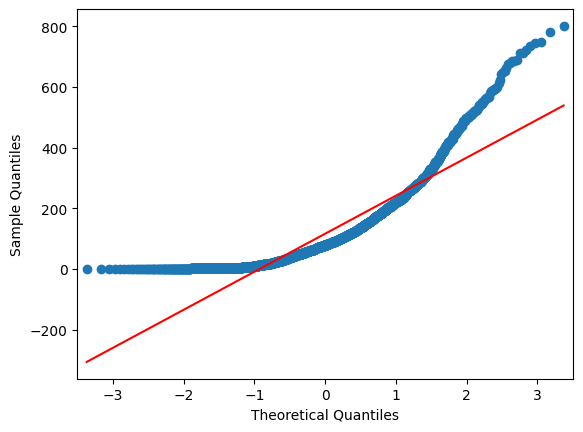

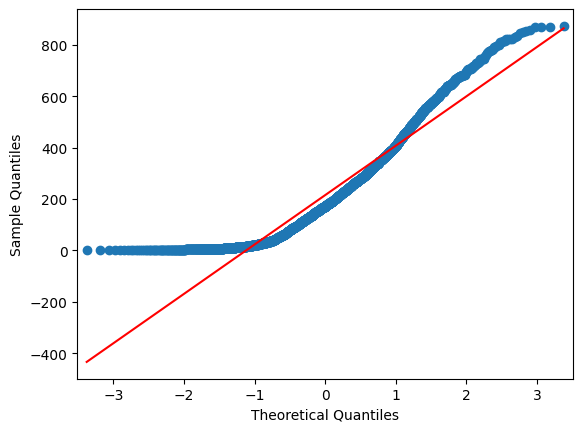

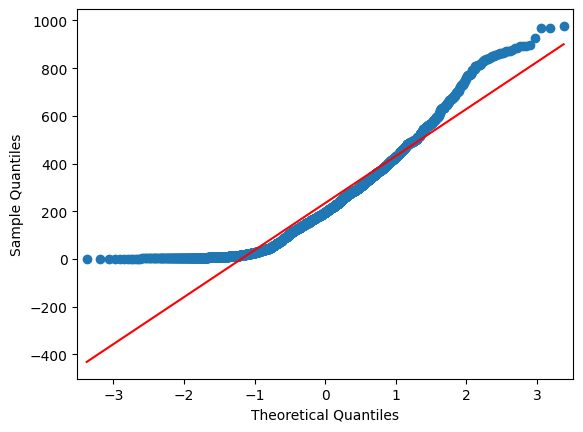

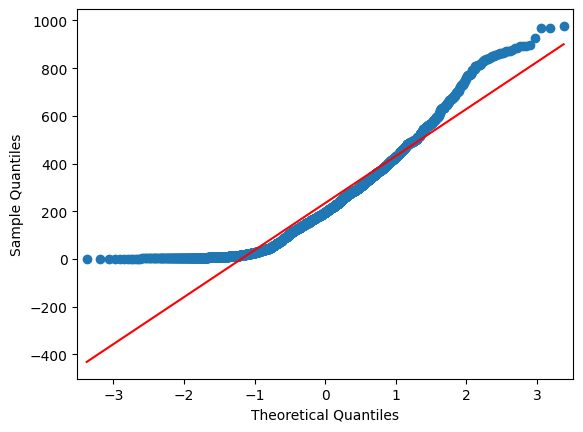

In [ ]:
import warnings
warnings.filterwarnings('ignore', message='scipy.stats.shapiro: For N > 5000')

season_1 = df[df['season'] == '1']['count']
season_2 =  df[df['season'] == '2']['count']
season_3 = df[df['season'] == '3']['count']
season_4 = df[df['season'] == '4']['count']

##Shapiro-Test
test_stat1, p_value1 = shapiro(season_1)
test_stat2, p_value2 = shapiro(season_2)
test_stat2, p_value3 = shapiro(season_3)
test_stat2, p_value4 = shapiro(season_4)

print(f"Shapiro_test value - season_1:{p_value1}",
      f"Shapiro_test value - season_2:{p_value2}",
      f"Shapiro_test value - season_3:{p_value3}",
      f"Shapiro_test value - season_4:{p_value4}",
      sep='\n')

#Kurtosis and Skewness Test
print(f"kurtosis:{df['season'].astype('int').kurt()}",
      f"Skewness: {df['season'].astype('int').skew()}",
      sep='\n')

#Q-Q plot
fig_1 = sm.qqplot(season_1, line='s')
fig_2 = sm.qqplot(season_2, line='s')
fig_3 = sm.qqplot(season_3, line='s')
fig_4 = sm.qqplot(season_3, line='s')




* All four p-values (e.g., 8.74e-49) are far, far smaller than your significance level ($\alpha = 0.05$).

**Conclusion:** You reject the null hypothesis for normality. This confirms, once again, that your count data is not normally distributed.


 * **Homogeneity of Variance (Equal Variances):** We can take Levene's test

In [ ]:
season_1 = df[df['season'] == '1']['count']
season_2 =  df[df['season'] == '2']['count']
season_3 = df[df['season'] == '3']['count']
season_4 = df[df['season'] == '4']['count']

#Levene's test for checking variances of season
test_stat1, p_value1 = levene(season_1,season_2,season_3,season_4)

p_value1


np.float64(1.0147116860043298e-118)

**Conclusion:**

**P-Value:** 1.01e-118 (an extremely small number).

**Conclusion:** This p-value is also far less than 0.05. Therefore, you reject the null hypothesis for equal variances. This means the variances (spread) of the count data are not equal across the four seasons. (Your boxplots showed this as well—the "boxes" were different heights).


#### **11.4.2 Run One way ANOVA test**

* Generally,If some assumptions fail (levene’s test or Shapiro-wilk test), we cannot the standard ANOVA test but it question it is mentioned to continue doing the analysisc if some assumptions fail even but double check using visual analysis and report wherever necessary

In [ ]:
season_1 = df[df['season'] == '1']['count']
season_2 =  df[df['season'] == '2']['count']
season_3 = df[df['season'] == '3']['count']
season_4 = df[df['season'] == '4']['count']

#One-way test for checking significant relationship between season
f_stats, p_value = f_oneway(season_1, season_2, season_3,season_4)
p_value

np.float64(6.164843386499654e-149)

* p-value (6.164843386499654e-149)> $\alpha$ (0.05)
Decision: This proves there is a statistically significant relationship between season and the number of bike rentals.

#### **11.4.3 Inferences,Conclusions and Recommendations**

**Inferences and Conclusions**

**Statistical Inference:** We rejected the Null Hypothesis ($H_0$). The p-value of 6.164e-149 is far below our 0.05 significance level. This proves there is a <font color='brown'>statistically significant difference</font> in the average number of bike rentals across the four seasons.

**Business Conclusion & Recommendation:** Our ANOVA test confirms that the large differences we saw in our EDA boxplots are real and not due to random chance. The demand is <font color='brown'>not the same</font> throughout the year.

* Based on the boxplots, demand is <font color='brown'>highest in Summer(3)</font> , followed closely by <font color='brown'>Fall(2)</font>  and <font color='brown'>Spring (4)</font> . Demand is lowest by a very large margin in <font color='brown'>Winter (1).</font>

**Recommendation:** Yulu must "maintain the rental bike stock based on the season."

**Peak Seasons (Summer, Fall, Spring):** Yulu should plan for maximum fleet deployment and marketing to capitalize on the high, predictable demand.

**Off-Peak Season (Winter):** Yulu can significantly <font color='brown'>reduce its active fleet</font>  during the winter. This is a key operational insight. This will save money on battery charging and street-level maintenance. This is the ideal time to perform heavy maintenance, repair damages, and prepare the full fleet for the upcoming busy spring season.

## **12.Check if the Weather conditions are significantly different during different Seasons?**



### **12.1 Formulation of Null and Alternater Hypotheses**

1. **H0​**: <font color='orange'>Seasons and Weather conditions are independent</font>​

2. **Ha​**: <font color='orange'>Seasons and Weather conditions are dependent​​/associated</font>


### **12.2 Select an appropriate test**

* We can use a Chi-square Test test.

Because we are checking whether 2 categorical variables are dependent/not.

### **12.3 Set a significance level ($\alpha$)**

* Significance Level ($\alpha$): **0.05**

### **12.4 Contingency Table against ‘Weather’ & ‘Season’ columns**

* A key assumption of this test is that the <font color='brown'>Expected count in each cell should not be too low</font> . A common rule of thumb is that all expected counts should be at least 1, and 80% of them should be at least 5.

* But our weather=4 category only has 1 observation, the expected counts for its cells (e.g., 'Winter and Heavy Rain') will be tiny, like 0.25. This violates the test's assumption and makes the resulting p-value unreliable.

* So,we need to filter the DataFrame to remove rows where weather == 4

In [ ]:
#Dropping the weather == 4 row
df_w_s = df[df['weather'] != '4']
df_w_s

,datetime,season,holiday,workingday,weather,temp,temp_category,atemp_category,humidity,humidity_category,windspeed,windspeed_category,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,Cold,Feels Mild,81,Humid,0.0000,Calm,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,Cold,Feels Mild,80,Humid,0.0000,Calm,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,Cold,Feels Mild,80,Humid,0.0000,Calm,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,Cold,Feels Mild,75,Humid,0.0000,Calm,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,Cold,Feels Mild,75,Humid,0.0000,Calm,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,Mild,Feels Mild,50,Comfortable,26.0027,Windy,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,Mild,Feels Mild,57,Comfortable,15.0013,Light Breeze,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,Mild,Feels Mild,61,Humid,15.0013,Light Breeze,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,Mild,Feels Mild,61,Humid,6.0032,Calm,12,117,129


In [ ]:
#Contingency Table between weather and season
cont_table = pd.crosstab(df_w_s['weather'],df_w_s['season'])
cont_table

season,1,2,3,4
weather,,,,
1,1759,1801,1930,1702
2,715,708,604,807
3,211,224,199,225


### **12.5 Calculate test statistics/p-value**

In [ ]:
#Chi-square test for weather and season
chi_stat, p_value, df, exp_freq = chi2_contingency(cont_table)
chi_stat, p_value, df, exp_freq

(np.float64(46.101457310732485),
 np.float64(2.8260014509929403e-08),
 6,
 array([[1774.04869086, 1805.76352779, 1805.76352779, 1806.42425356],
        [ 699.06201194,  711.55920992,  711.55920992,  711.81956821],
        [ 211.8892972 ,  215.67726229,  215.67726229,  215.75617823]]))

* Chi-Square Statistic: 46.10
* P-Value: 2.826e-08

Since,p-value ($2.826e-08$) < $\alpha$ (0.05), We reject the Null Hypothesis ($H_0$)

### **12.6 Inferences,Conclusions and Recommendations**

**Conclusion:**

The Null Hypothesis ($H_0$) stated that "Seasons and Weather conditions are independent." Since we rejected $H_0$, our conclusion is the opposite:

<font color=brown>**There is a statistically significant dependency between season and weather.**</font>

In simple terms, this test proves what we logically expect: the type of weather you get is **not random** throughout the year. It is **dependent on the season**. For example, 'Light Rain/Snow' (Weather 3) is much more likely to occur in 'Winter' (Season 1) than in 'Summer' (Season 3).

**Recommendations:**
1. **Redundant Planning:** This test confirms that season and weather are linked. When Yulu plans for "seasonal" changes in demand, they are, in large part, already planning for "weather" changes. For example, planning for 'Winter' (Season 1) is planning for the increased likelihood of 'Light Rain' (Weather 3) days, which our ANOVA test proved have the lowest demand.

2. **Beware of Confounding Effects:** Because season and weather are dependent and they both significantly impact count, their effects are tangled (or "confounded"). This means a simple analysis might misjudge why demand drops in winter. This test tells us it's a <font color=brown>combined effect</font>: part of the drop is due to the season itself (e.g., fewer daylight hours, general cold) and part is due to the bad weather associated with that season.

## **13. Actionable Recommendations for Yulu**

1. **Marketing Strategy: Segment by Day Type**

Our analysis showed that the total number of rentals is the same on working vs. non-working days. However, the user base is completely different.

  * **T-Test Result:** No significant difference in total count.

  * **EDA Insight:**

  * **Working Days:** Dominated by registered (commuter) users.

  * **Non-Working Days**: Dominated by casual (leisure) users.

  **Recommendation:**

  * **On Workdays (Mon-Fri)**: Focus marketing and bike placement on commuter routes, corporate offices, and metro stations. Target registered users with reliability and "commuter pass" promotions.

  * **On Non-Working Days (Weekends/Holidays)**: Shift marketing and bike placement to parks, residential areas, and leisure spots. Target casual users with "all-day rentals" or "family pack" promotions.

2. **Operations: Use Weather & Season for Fleet Management**

We proved that both weather and season have a statistically significant impact on demand. Yulu can use this to optimize its fleet, saving money on maintenance and maximizing revenue.

  * **ANOVA Results:** Both weather and season have a massive impact on rental count.

**Recommendations:**

**Plan by Season:**

* <font color=purple>Peak Seasons (Summer, Fall, Spring):</font> Deploy the maximum number of bikes to meet high demand.

* <font color=purple>Off-Peak (Winter):</font> Significantly reduce the active fleet. This is the ideal time to perform heavy maintenance, battery replacements, and prepare bikes for the spring rush.

**React to Daily Weather:**

* <font color=purple>weather=1 (Clear)</font>: Maximize bike availability. These are the highest-demand days.

* <font color=purple>weather=3 (Light Rain/Snow)</font>: Minimize the active fleet. Demand is lowest. Pull bikes for maintenance.

**Focus on Comfort (Heat & Humidity):**

* <font color=purple>Demand is highest on 'Hot and Dry' days</font>. Do not reduce the fleet on hot days; this is a peak condition.

* <font color=purple>Demand is lowest on 'Calm and Humid' days</font>. A lack of wind (calm) is a negative sign, as it's linked to uncomfortable humidity. A 'Light Breeze' is a positive sign and is associated with peak demand.

3. **User Insights: Casual Riders are More Weather-Sensitive**
Our correlation heatmap showed that different user types react to weather with different sensitivity.

* **Correlation Insight:** casual user rentals had a stronger correlation with temp (0.47) and humidity (-0.35) than registered users (0.32 and -0.27).

**Recommendation:** Yulu can expect registered (commuter) users to be more reliable, even in mediocre weather. However, the casual user base is highly weather-dependent and will only show up if conditions are good. This reinforces the need to manage fleet availability based on the daily forecast.